*FIT5202 Data processing for Big data* | **Assessment 2 - Phase 3: Machine Learning Pipeline**

TP3 2021 - Group 8 :

Yean Ee TAN	18721796, Imran SHAH 12271144, Soo Hui LEE 31336159, Salih SAFFET 27919722






<a class="anchor" id="settings_note"></a>
<div style="background:rgba(219,175,181,0.2);padding:10px;border-radius:4px">
<strong>NOTE - There are some settings for this notebook that may require tuning to your specific environment prior to running, please see <a href=#special_settings>VM Dependent / Tuning Settings</a><strong>
</div>

[Go to Table of Contents](#toc)
<a class="anchor" id="intro"></a>
<div style="background:rgba(0,80,80,0.2);padding:10px;border-radius:4px"><h2>Introduction: Road Accident Analysis in Victoria </h2>
<hr/>
</div>

The dataset records all people involved in the accidents, including drivers, passengers, pedestrian, motorcyclist etc. The classification goals is to predict whether the person will suffer injury from the road accident.

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <strong style="color:#006DAE"> Objective:</strong>  Will the person suffer injury from road accident? </div>

**Datasets :**(in order)  

- **ID of the records:** `ACCIDENT_NO`, `PERSON_ID`, `NODE_ID`, `VEHICLE_ID`   
- `SEVERITY` : desribe the road accident level. The level of severity is determined based on `INJ_LEVEL` & `TAKEN_HOSPITAL`([VicRoads](https://data.vicroads.vic.gov.au/metadata/Crashstats_user_Guide_and_Appendices.pdf), n.d)
- `INJ_LEVEL` : describe the injury level of an invividual
- **Details of the accidents:** `ACCIDENT_MONTH`, `ACCIDENT_HOUR`, `DAY_OF_WEEK`, `ACCIDENT_TYPE`, `DCA`, `LIGHT_COND`, `ROAD_GEOMETRY`, `POLICE_ATTEND` `SPEED_ZONE`  
- **Details of the surface condition:** `SURFACE_DRY`, `SURFACE_WET`, `SURFACE_MUDDY`, `SURFACE_SNOWY`, `SURFACE_ICY`, `SURFACE_UNKNOWN`   
- **Details of the atmostpheric condition:** `ATMOSPH_CLEAR`, `ATMOSPH_RAINING`, `ATMOSPH_SNOWING`, `ATMOSPH_FOG`, `ATMOSPH_SMOKE`, `ATMOSPH_DUST`, `ATMOSPH_STRONG_WINDS`, `ATMOSPH_UNKNOWN`  
- **Details of the accident's location:** `NODE_TYPE`, `LGA_NAME`, `REGION_NAME`, `DEG_URBAN_NAME`   
- **Details of person involved in the accident:** `SEX`, `AGE_GROUP`, `LICENCE_STATE`, `ROAD_USER_TYPE`, `TAKEN_HOSPITAL`, `EJECTED_CODE`, `SEATING_POSITION`, `HELMET_BELT_WORN`, `PEDEST_MOVEMENT`  
- **Details of vehicle involed in the accident:** `VEHICLE_AGE_GROUP`, `REG_STATE_GRP`, `VEHICLE_TYPE_DESC`, `FUEL_TYPE_DESC`, `VEHICLE_MAKE`, `TRAILER_TYPE`, `VEHICLE_COLOUR_1`, `VEHICLE_COLOUR_2`, `VEHICLE_DCA`, `VEHICLE_MOVEMENT`, `VEHICLE_CHANGED_DIRECTION`, `DRIVER_INTENT`, `ROAD_SURFACE_TYPE`, `TOTAL_NO_OCCUPANTS`, `INITIAL_IMPACT`, `LEVEL_OF_DAMAGE`, `CAUGHT_FIRE`, `LAMPS_ON`, `TRAFFIC_CONTROL`

There are multiple people involved in an accident. An accident involves multiple people including pedestrian. 

**REFERENCES:**  

VicRoads. (n.d.). [VicRoads Crash Stats User Guide and Appendices](https://data.vicroads.vic.gov.au/metadata/Crashstats_user_Guide_and_Appendices.pdf), p53. Retrieved from https://data.vicroads.vic.gov.au/metadata/Crashstats_user_Guide_and_Appendices.pdf   



In this phase, we will apply machine learning process to the dataset, with the following key steps:

1. **Data Loading and Preparation:** data will be loaded and removed record-IDs and remove co-related predictors/variables. Based on VicRoads's definition, a `SEVERITY` of an accident is determining based on `INJ_LEVEL` & `TAKEN HOSPITAL`.


*Transformation of the dataset, model selection and assessment is an iterative process, in identifying the best machine learning algorithm in predicting whether the person received an injury from the road accident.*   

2. **Transformation & Feature Selection :** Variables/predictors will be improved or will be dropped based on the result produced in `Feature Importance` of the model assessment stage. This activity tries to improve the modelling.
3. **Features Engineering**: Build pipeline to transform variables into features with StringIndexer, One-Hot-Encoding and VectorAssembler.
3. **Model Selection :** Applying three different Machine Learning Algorithms for classification, namely Logistic Regression, Decision Tree and Random Forest with the same train/test dataset. In addition, to prevent overfitting of the modelling, cross validation will be used in identifying the best model.  
4. **Model Assessment :** Each model's result will be assessed with different metrics: Accuracy, Precision, Recall, F1 and ROC.


<a class="anchor" id="toc"></a>
## Table of Contents

* [Introduction](#intro)
* [Import library](#import)
* [Initialize SparkSession](#initialize)
* [Data Loading and Preparation](#data_loading)
    * [Transformation](#transformation)
    * [Train/Test Split](#split)
* [User Defined Functions](#functions)   
    * **Feature Engineering**
    * **Model Selection** : Logistic Regression, Decison Tree, Random Forest 
    * **Model Assessment** : Confusion Matrix, Receiver Operating Characteristic Curve (ROC), Feature Importance
    * **Tree Visualisation**: Display tree with plain english
* [Model Assessment](#model-assessment)
    * [Pass 1](#pass1), [Pass 2](#pass2), [Pass 3](#pass3), [Pass 4](#pass4)
    * [Summary](#summary_pass)
* [Best Model Visualisation](#visualisation)

[Back to Table of Contents](#toc)
<a class="anchor" id="import"></a>
<div style="background:rgba(0,80,80,0.2);padding:10px;border-radius:4px"><h2>Import library</h2>
<hr/>
</div>

In [3]:
#Stop any previous running spark session (if re-running whole notebook )
try:
    if (sc.startTime) > 0:
        spark.stop()
except:
    pass

In [4]:
# Run this to ensure the latest version of PyArrow
#pip install PyArrowa

##%%sh 
##env|sort

In [5]:
# import libraries
import time, datetime

from pyspark.sql.types import FloatType, ArrayType
from pyspark.sql.functions import col, when
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator,CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## display all columns and rows for Pandas Dataframe
# TURN ON for exploration phase.
# TURN OFF this options before submission for better performance
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# keeping track on the processing time
#NB Start time
nbstart = time.time()

[Back to Table of Contents](#toc)
<a class="anchor" id="initialize"></a>
<div style="background:rgba(0,80,80,0.2);padding:10px;border-radius:4px"><h2>Initialize Spark Session</h2>
<hr/>
</div>

<a class="anchor" id="special_settings"></a>
<div style="background:rgba(219,175,181,0.2);padding:10px;border-radius:4px">
<strong> VM Dependent Tuning / Settings</strong>

Change the next cell as per your processing requirements, different VM hosts will require different settings

    
<strong> Also please make sure you start jupyter notebook with the following parameters for all cells to run 
    sucessfully</strong>
    
    `jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10`
    
Without this parameter the decision tree print out will not displau
    
</div>

In [6]:
#VM Memory and Cores to assign to spark session
vmem = '20g' #Change to your VM Config
vcores = 8  # Change to your VM config

#Spark Memory Config - Assume assign all as per above
spcfgsettings = [('spark.executor.memory', vmem), 
 ('spark.executor.cores', str(vcores)), 
 ('spark.cores.max', str(vcores)), 
 ('spark.driver.memory',vmem)]

# If you want to run entire notebook for a limited number of data rows, 
run_with_limited_data = False
# If True then how many rows
run_for_rows=800


In [7]:
# Import SparkConf class into program
from pyspark import SparkConf

# Set the options to run Spark in local mode with different processors requirements.
master = "local[*]"

# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Road Accident Analysis in Victoria Phase 3"

# Setup configuration parameters for Spark
#spark_conf = SparkConf().setMaster(master).setAppName(app_name)
# test with force parameters with higher machine specs
spark_conf = SparkConf().setMaster(master).setAppName(app_name).setAll(spcfgsettings)

# Import SparkContext and SparkSession classes
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Create SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [8]:
# get SparkSession info
sc.getConf().getAll()

[('spark.driver.port', '39029'),
 ('spark.app.id', 'local-1623646072108'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', '10.0.2.15'),
 ('spark.executor.memory', '20g'),
 ('spark.driver.memory', '20g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.cores.max', '8'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.name', 'Road Accident Analysis in Victoria Phase 3'),
 ('spark.executor.cores', '8'),
 ('spark.ui.showConsoleProgress', 'true')]

In [9]:
#spark session info
spark

[Back to Table of Contents](#toc)
<a class="anchor" id="data_loading"></a>
<div style="background:rgba(0,80,80,0.2);padding:10px;border-radius:4px"><h2>Data loading and Preparation</h2>
<hr/>
</div>

In [10]:
# Import Clean dataset from Phase 2: 
df_crash = spark.read.format('parquet')\
            .option('header',True).option('escape','"')\
            .load('clean_data/df_crash_final.parquet/*.parquet')\
            .cache()

In [11]:
# check import shape
print("Number of Records : ", df_crash.count(), " Number of Columns : ",len(df_crash.columns))

Number of Records :  490948  Number of Columns :  61


In [12]:
# check Schema (in shorter view)
df_crash

DataFrame[ACCIDENT_NO: string, PERSON_ID: string, NODE_ID: int, VEHICLE_ID: string, SEVERITY: string, INJ_LEVEL: string, ACCIDENT_MONTH: int, ACCIDENT_HOUR: string, DAY_OF_WEEK: string, ACCIDENT_TYPE: string, DCA: string, LIGHT_COND: string, ROAD_GEOMETRY: string, POLICE_ATTEND: string, SPEED_ZONE: string, SURFACE_DRY: string, SURFACE_WET: string, SURFACE_MUDDY: string, SURFACE_SNOWY: string, SURFACE_ICY: string, SURFACE_UNKNOWN: string, ATMOSPH_CLEAR: string, ATMOSPH_RAINING: string, ATMOSPH_SNOWING: string, ATMOSPH_FOG: string, ATMOSPH_SMOKE: string, ATMOSPH_DUST: string, ATMOSPH_STRONG_WINDS: string, ATMOSPH_UNKNOWN: string, NODE_TYPE: string, LGA_NAME: string, REGION_NAME: string, DEG_URBAN_NAME: string, SEX: string, AGE_GROUP: string, LICENCE_STATE: string, ROAD_USER_TYPE: string, TAKEN_HOSPITAL: string, EJECTED_CODE: string, SEATING_POSITION: string, HELMET_BELT_WORN: string, PEDEST_MOVEMENT: string, VEHICLE_AGE_GROUP: string, REG_STATE_GRP: string, VEHICLE_TYPE_DESC: string, FUE

In [13]:
#View Data sample
df_crash.limit(5).toPandas()

ACCIDENT_NO PERSON_ID  NODE_ID VEHICLE_ID                   SEVERITY  \
0  T20060000414         A   277150          A  2-Serious injury accident   
1  T20060000414        01   277150          B  2-Serious injury accident   
2  T20060000414         B   277150          B  2-Serious injury accident   
3  T20060000935         A   202810          A    3-Other injury accident   
4  T20060000935         B   202810          B    3-Other injury accident   

          INJ_LEVEL  ACCIDENT_MONTH ACCIDENT_HOUR DAY_OF_WEEK  \
0    3-Other Injury               1  MORNING PEAK   Wednesday   
1  2-Serious Injury               1  MORNING PEAK   Wednesday   
2    3-Other Injury               1  MORNING PEAK   Wednesday   
3    3-Other Injury               1      OFF-PEAK     Tuesday   
4     4-Not Injured               1      OFF-PEAK     Tuesday   

            ACCIDENT_TYPE                                DCA LIGHT_COND  \
0  Collision with vehicle  CROSS TRAFFIC(INTERSECTIONS ONLY)        Day   
1  Collision with vehicle  CROSS TRAFFIC(INTERSECTIONS ONLY)        Day   
2  Collision with vehicle  CROSS TRAFFIC(INTERSECTIONS ONLY)        Day   
3  Collision with vehicle                          LEFT REAR        Day   
4  Collision with vehicle                          LEFT REAR        Day   

         ROAD_GEOMETRY POLICE_ATTEND     SPEED_ZONE SURFACE_DRY SURFACE_WET  \
0   Cross intersection           Yes  100-110 km/hr          No          No   
1   Cross intersection           Yes  100-110 km/hr          No          No   
2   Cross intersection           Yes  100-110 km/hr          No          No   
3  Not at intersection            No       50 km/hr         Yes          No   
4  Not at intersection            No       50 km/hr         Yes          No   

  SURFACE_MUDDY SURFACE_SNOWY SURFACE_ICY SURFACE_UNKNOWN ATMOSPH_CLEAR  \
0            No            No          No             Yes           Yes   
1            No            No          No             Yes           Yes   
2            No            No          No             Yes           Yes   
3            No            No          No              No           Yes   
4            No            No          No              No           Yes   

  ATMOSPH_RAINING ATMOSPH_SNOWING ATMOSPH_FOG ATMOSPH_SMOKE ATMOSPH_DUST  \
0              No              No          No            No           No   
1              No              No          No            No           No   
2              No              No          No            No           No   
3              No              No          No            No           No   
4              No              No          No            No           No   

  ATMOSPH_STRONG_WINDS ATMOSPH_UNKNOWN         NODE_TYPE  \
0                   No              No  Non-intersection   
1                   No              No  Non-intersection   
2                   No              No  Non-intersection   
3                   No              No  Non-intersection   
4                   No              No  Non-intersection   

               LGA_NAME                     REGION_NAME  DEG_URBAN_NAME  \
0  MORNINGTON PENINSULA  METROPOLITAN SOUTH EAST REGION      MELB_URBAN   
1  MORNINGTON PENINSULA  METROPOLITAN SOUTH EAST REGION      MELB_URBAN   
2  MORNINGTON PENINSULA  METROPOLITAN SOUTH EAST REGION      MELB_URBAN   
3               GEELONG            SOUTH WESTERN REGION  RURAL_VICTORIA   
4               GEELONG            SOUTH WESTERN REGION  RURAL_VICTORIA   

      SEX AGE_GROUP LICENCE_STATE ROAD_USER_TYPE TAKEN_HOSPITAL  \
0    Male     45-54      Overseas        Drivers            Yes   
1  Female     45-54     Not known     Passengers            Yes   
2  Female     55-64      Victoria        Drivers             No   
3  Female     55-64      Victoria        Drivers             No   
4  Female     45-54      Victoria        Drivers      Not known   

                            EJECTED_CODE SEATING_POSITION HELMET_BELT_WORN  \
0                         Not

<a class="anchor" id="transformation"></a>
### Transformation

In [14]:
# Exploration for different combination by Colour

df_crash.groupBy("VEHICLE_COLOUR_1")\
        .pivot("INJ_LEVEL").count()\
        .sort("VEHICLE_COLOUR_1")\
        .limit(20).toPandas()       

VEHICLE_COLOUR_1  1-Fatality  2-Serious Injury  3-Other Injury  \
0             Black       381.0              8285           18658   
1              Blue       472.0              9757           21924   
2             Brown        30.0               451            1197   
3             Cream         8.0               164             359   
4              Fawn        32.0               464            1042   
5              Gold        72.0              1630            4001   
6             Green       225.0              4324            8991   
7              Grey       146.0              3809           11498   
8            Maroon        55.0              1113            2300   
9             Mauve         NaN                14              20   
10              N/A       622.0              8225           11780   
11           Orange        26.0               930            1736   
12             Pink         1.0                54             145   
13           Purple        20.0               348             848   
14              Red       436.0              8404           17487   
15           Silver       472.0             10127           25876   
16   Unknown or N/A       153.0              5987           15673   
17            White       832.0             14446           35099   
18           Yellow        57.0              1307            3153   

    4-Not Injured  
0           23078  
1           26547  
2            1681  
3             553  
4            1464  
5            6005  
6           11516  
7           17902  
8            3153  
9              41  
10            668  
11           1057  
12            151  
13            894  
14          19166  
15          37689  
16           8314  
17          59758  
18           5645

In [15]:
# additional transformation
# removing ID columns
# during modelling, required to perform further adjustment to the dataset for better modelling prediction.

df = df_crash.withColumn("HELMET_BELT_WORN",
                         when(col("HELMET_BELT_WORN") == "Seatbelt/restraint not fitted", "No")\
                        .when(col("HELMET_BELT_WORN") == "Seatbelt worn", "Yes")\
                        .when(col("HELMET_BELT_WORN") == "Seatbelt not worn", "No")\
                        .when(col("HELMET_BELT_WORN") == "Crash helmet worn", "Yes")\
                        .when(col("HELMET_BELT_WORN") == "Child restraint not worn", "No")\
                        .when(col("HELMET_BELT_WORN") == "Crash helmet not worn", "No")\
                        .when(col("HELMET_BELT_WORN") == "Child restraint worn", "No")\
                        .otherwise(col("HELMET_BELT_WORN")))\
        .withColumnRenamed("HELMET_BELT_WORN","SAFETY_WORN")\
        .withColumn("AGE_GROUP",
                         when(col("AGE_GROUP") == "25-34", "25-64")\
                        .when(col("AGE_GROUP") == "35-44", "25-64")\
                        .when(col("AGE_GROUP") == "45-54", "25-64")\
                        .when(col("AGE_GROUP") == "55-64", "25-64")\
                        .when(col("AGE_GROUP") == "65-69", "65+")\
                        .when(col("AGE_GROUP") == "70+", "65+")
                        .otherwise(col("AGE_GROUP")))\
        .withColumn('TRAFFIC_CONTROL',
                         when(col("TRAFFIC_CONTROL") == "Flashing lights", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "Giveway sign", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "N/A", "Unknown/Not Applicable")\
                        .when(col("TRAFFIC_CONTROL") == "No control", "No")\
                        .when(col("TRAFFIC_CONTROL") == "Other", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "Out of order", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "Ped. crossing", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "Ped. lights", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "Police", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "RX Bells/Lights", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "RX Gates/Booms", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "RX No control", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "Roundabout", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "School Flags", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "School No flags", "No")\
                        .when(col("TRAFFIC_CONTROL") == "Stop sign", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "Stop-go lights", "Yes")\
                        .when(col("TRAFFIC_CONTROL") == "Unknown", "Unknown/Not Applicable")\
                        .otherwise("No"))\
        .withColumn("LEVEL_OF_DAMAGE",
                         when(col("LEVEL_OF_DAMAGE") == "Extensive (unrepairable)", "Extensive (unrepairable)")\
                        .when(col("LEVEL_OF_DAMAGE") == "Major (unit towed away)", "Major")\
                        .when(col("LEVEL_OF_DAMAGE") == "Minor", "Minor")\
                        .when(col("LEVEL_OF_DAMAGE") == "Moderate (driveable vehicle)", "Moderate")\
                        .when(col("LEVEL_OF_DAMAGE") == "Moderate (unit towed away)", "Moderate")\
                        .when(col("LEVEL_OF_DAMAGE") == "N/A", "Unknown/Not Applicable")\
                        .when(col("LEVEL_OF_DAMAGE") == "Nil damage", "Nil damage")\
                        .when(col("LEVEL_OF_DAMAGE") == "Not known", "Unknown/Not Applicable")
                        .otherwise("Unknown/Not Applicable"))\
        .withColumn("LAMPS_ON",
                        when(col("LAMPS_ON") == "N/A", "Not Applicable")\
                        .otherwise(col("LAMPS_ON")))\
        .withColumn("NO_OCCUPANTS",
                         when(col("TOTAL_NO_OCCUPANTS") == 0, "Unknown")\
                        .when(((col("TOTAL_NO_OCCUPANTS") >= 1) & (col("TOTAL_NO_OCCUPANTS") <= 2)), "1-2")\
                        .when(((col("TOTAL_NO_OCCUPANTS") >= 3) & (col("TOTAL_NO_OCCUPANTS") <= 5)), "3-5")\
                        .when((col("TOTAL_NO_OCCUPANTS") >= 6), "6+")\
                        .otherwise("Unknown"))\
        .withColumn("LIGHT_COND",
                         when(col("LIGHT_COND").contains("Dark"),"Dark")
                         .otherwise(col("LIGHT_COND")))\
        .withColumn("PERSON_INJURED",
                         when(col("INJ_LEVEL") == "4-Not Injured","No")\
                        .otherwise("Yes"))\
        .withColumn("CAUGHT_FIRE",
                         when(col("CAUGHT_FIRE") == "N/A", "Not Applicable")\
                         .otherwise(col("CAUGHT_FIRE")))\
        .withColumn("TRAILER_TYPE",
                         when(col("TRAILER_TYPE") == "N/A", "Not Applicable")\
                         .otherwise(col("TRAILER_TYPE")))\
        .withColumn("VEHICLE_COLOUR_1",
                         when(col("VEHICLE_COLOUR_1") == "N/A", "Unknown or N/A")\
                         .otherwise(col("VEHICLE_COLOUR_1")))\
        .withColumn("VEHICLE_COLOUR_2",
                         when(col("VEHICLE_COLOUR_2") == "N/A", "Unknown or N/A")\
                         .otherwise(col("VEHICLE_COLOUR_2")))\
        .withColumn("DRIVER_INTENT",
                         when(col("DRIVER_INTENT") == "Slow/stopping","Stationary/Stopping")\
                        .when(col("DRIVER_INTENT") == "Stationary accident","Stationary/Stopping")\
                        .when(col("DRIVER_INTENT") == "Merging","Merging/Overtaking")\
                        .when(col("DRIVER_INTENT") == "Going straight ahead","Going straight ahead")\
                        .when(col("DRIVER_INTENT") == "Reversing","Other")\
                        .when(col("DRIVER_INTENT") == "Turning right","Turning right")\
                        .when(col("DRIVER_INTENT") == "Leaving a driveway","Other")\
                        .when(col("DRIVER_INTENT") == "U turning ","Other")\
                        .when(col("DRIVER_INTENT") == "Parked illegally", "Parked/Parking")\
                        .when(col("DRIVER_INTENT") == "Not known","Other")\
                        .when(col("DRIVER_INTENT") == "Stationary broken...","Stationary/Stopping")\
                        .when(col("DRIVER_INTENT") == "Parking or unparking","Parked/Parking")\
                        .when(col("DRIVER_INTENT") == "Parked legally","Parked/Parking")\
                        .when(col("DRIVER_INTENT") == "N/A","Other")\
                        .when(col("DRIVER_INTENT") == "Other stationary","Stationary/Stopping")\
                        .when(col("DRIVER_INTENT") == "Out of control","Out of Control")\
                        .when(col("DRIVER_INTENT") == "Avoiding animals","Avoiding animals")\
                        .when(col("DRIVER_INTENT") == "Wrong way","Other")\
                        .when(col("DRIVER_INTENT") == "Turning left","Turning left")\
                        .when(col("DRIVER_INTENT") == "Overtaking","Merging/Overtaking")\
                        .when(col("DRIVER_INTENT") == "Changing lanes","Merging/Overtaking")\
                        .otherwise("Other"))\
        .withColumn("VEHICLE_MOVEMENT",
                        when(col("VEHICLE_MOVEMENT") == "Slow/stopping","Stationary/Stopping")\
                        .when(col("VEHICLE_MOVEMENT") == "Stationary accident","Stationary/Stopping")\
                        .when(col("VEHICLE_MOVEMENT") == "Merging","Merging/Overtaking")\
                        .when(col("VEHICLE_MOVEMENT") == "Going straight ahead","Going straight ahead")\
                        .when(col("VEHICLE_MOVEMENT") == "Reversing","Other")\
                        .when(col("VEHICLE_MOVEMENT") == "Turning right","Turning right")\
                        .when(col("VEHICLE_MOVEMENT") == "Leaving a driveway","Other")\
                        .when(col("VEHICLE_MOVEMENT") == "U turning ","Other")\
                        .when(col("VEHICLE_MOVEMENT") == "Parked illegally", "Parked/Parking")\
                        .when(col("VEHICLE_MOVEMENT") == "Not known","Other")\
                        .when(col("VEHICLE_MOVEMENT") == "Stationary broken...","Stationary/Stopping")\
                        .when(col("VEHICLE_MOVEMENT") == "Parking or unparking","Parked/Parking")\
                        .when(col("VEHICLE_MOVEMENT") == "Parked legally","Parked/Parking")\
                        .when(col("VEHICLE_MOVEMENT") == "N/A","Other")\
                        .when(col("VEHICLE_MOVEMENT") == "Other stationary","Stationary/Stopping")\
                        .when(col("VEHICLE_MOVEMENT") == "Out of control","Out of Control")\
                        .when(col("VEHICLE_MOVEMENT") == "Avoiding animals","Avoiding animals")\
                        .when(col("VEHICLE_MOVEMENT") == "Wrong way","Other")\
                        .when(col("VEHICLE_MOVEMENT") == "Turning left","Turning left")\
                        .when(col("VEHICLE_MOVEMENT") == "Overtaking","Merging/Overtaking")\
                        .when(col("VEHICLE_MOVEMENT") == "Changing lanes","Merging/Overtaking")\
                        .otherwise("Other"))\
        .withColumn("VEHICLE_TYPE_DESC",
                         when(col("VEHICLE_TYPE_DESC") == "Moped","Motorcycle/Scooter")\
                        .when(col("VEHICLE_TYPE_DESC") == "Motor Scooter","Motorcycle/Scooter")\
                        .when(col("VEHICLE_TYPE_DESC") == "Motor Cycle","Motorcycle/Scooter")\
                        .when(col("VEHICLE_TYPE_DESC") == "Bus/Coach","Bus/Coach/Minibus")\
                        .when(col("VEHICLE_TYPE_DESC") == "Mini Bus(9-13 seats)","Bus/Coach/Minibus")\
                        .when(col("VEHICLE_TYPE_DESC") == "Prime Mover (No of Trailers Unknown)","Prime Mover")\
                        .when(col("VEHICLE_TYPE_DESC") == "Prime Mover - Single Trailer","Prime Mover")\
                        .when(col("VEHICLE_TYPE_DESC") == "Prime Mover B-Double","Prime Mover")\
                        .when(col("VEHICLE_TYPE_DESC") == "Prime Mover B-Triple","Prime Mover")\
                        .when(col("VEHICLE_TYPE_DESC") == "Prime Mover Only","Prime Mover")\
                        .when(col("VEHICLE_TYPE_DESC") == "Heavy Vehicle (Rigid) > 4.5 Tonnes","Truck(Rigid/Heavy/Light)")\
                        .when(col("VEHICLE_TYPE_DESC") == "Light Commercial Vehicle (Rigid) <= 4.5 Tonnes GVM","Truck(Rigid/Heavy/Light)")\
                        .when(col("VEHICLE_TYPE_DESC") == "Rigid Truck(Weight Unknown)","Truck(Rigid/Heavy/Light)")\
                        .when(col("VEHICLE_TYPE_DESC") == "Horse (ridden or drawn)","Other Vehicle")\
                        .when(col("VEHICLE_TYPE_DESC") == "Parked trailers","Other Vehicle")\
                        .when(col("VEHICLE_TYPE_DESC") == "Unknown","Other Vehicle")\
                        .when(col("VEHICLE_TYPE_DESC") == "N/A", "Not Applicable")\
                        .otherwise(col("VEHICLE_TYPE_DESC")))\
        .withColumnRenamed("VEHICLE_TYPE_DESC","VEHICLE_TYPE")\
        .withColumn("ROAD_USER_TYPE", 
                             when(col('ROAD_USER_TYPE') == "Pillion Passengers","Passengers")\
                            .otherwise(col("ROAD_USER_TYPE")))\
        .withColumn("SPEED_ZONE", 
                             when(col('SPEED_ZONE') == "50 km/hr","50-60 km/hr")\
                            .when(col('SPEED_ZONE') == "60 km/hr","50-60 km/hr")\
                            .otherwise(col("SPEED_ZONE")))\
        .drop("ACCIDENT_NO","PERSON_ID","NODE_ID","VEHICLE_ID","SEVERITY","INJ_LEVEL","SURFACE_UNKNOWN",
              "ATMOSPH_UNKNOWN","TOTAL_NO_OCCUPANTS","TAKEN_HOSPITAL", "EJECTED_CODE")\
        .cache()


In [16]:
# display the result of transformation
df.limit(5).toPandas()

ACCIDENT_MONTH ACCIDENT_HOUR DAY_OF_WEEK           ACCIDENT_TYPE  \
0               1  MORNING PEAK   Wednesday  Collision with vehicle   
1               1  MORNING PEAK   Wednesday  Collision with vehicle   
2               1  MORNING PEAK   Wednesday  Collision with vehicle   
3               1      OFF-PEAK     Tuesday  Collision with vehicle   
4               1      OFF-PEAK     Tuesday  Collision with vehicle   

                                 DCA LIGHT_COND        ROAD_GEOMETRY  \
0  CROSS TRAFFIC(INTERSECTIONS ONLY)        Day   Cross intersection   
1  CROSS TRAFFIC(INTERSECTIONS ONLY)        Day   Cross intersection   
2  CROSS TRAFFIC(INTERSECTIONS ONLY)        Day   Cross intersection   
3                          LEFT REAR        Day  Not at intersection   
4                          LEFT REAR        Day  Not at intersection   

  POLICE_ATTEND     SPEED_ZONE SURFACE_DRY SURFACE_WET SURFACE_MUDDY  \
0           Yes  100-110 km/hr          No          No            No   
1           Yes  100-110 km/hr          No          No            No   
2           Yes  100-110 km/hr          No          No            No   
3            No    50-60 km/hr         Yes          No            No   
4            No    50-60 km/hr         Yes          No            No   

  SURFACE_SNOWY SURFACE_ICY ATMOSPH_CLEAR ATMOSPH_RAINING ATMOSPH_SNOWING  \
0            No          No           Yes              No              No   
1            No          No           Yes              No              No   
2            No          No           Yes              No              No   
3            No          No           Yes              No              No   
4            No          No           Yes              No              No   

  ATMOSPH_FOG ATMOSPH_SMOKE ATMOSPH_DUST ATMOSPH_STRONG_WINDS  \
0          No            No           No                   No   
1          No            No           No                   No   
2          No            No           No                   No   
3          No            No           No                   No   
4          No            No           No                   No   

          NODE_TYPE              LGA_NAME                     REGION_NAME  \
0  Non-intersection  MORNINGTON PENINSULA  METROPOLITAN SOUTH EAST REGION   
1  Non-intersection  MORNINGTON PENINSULA  METROPOLITAN SOUTH EAST REGION   
2  Non-intersection  MORNINGTON PENINSULA  METROPOLITAN SOUTH EAST REGION   
3  Non-intersection               GEELONG            SOUTH WESTERN REGION   
4  Non-intersection               GEELONG            SOUTH WESTERN REGION   

   DEG_URBAN_NAME     SEX AGE_GROUP LICENCE_STATE ROAD_USER_TYPE  \
0      MELB_URBAN    Male     25-64      Overseas        Drivers   
1      MELB_URBAN  Female     25-64     Not known     Passengers   
2      MELB_URBAN  Female     25-64      Victoria        Drivers   
3  RURAL_VICTORIA  Female     25-64      Victoria        Drivers   
4  RURAL_VICTORIA  Female     25-64      Victoria        Drivers   

  SEATING_POSITION SAFETY_WORN PEDEST_MOVEMENT VEHICLE_AGE_GROUP  \
0  Driver or rider         Yes  Not applicable               0-3   
1       Right-rear         Yes  Not applicable               4-7   
2  Driver or rider         Yes  Not applicable               4-7   
3  Driver or rider         Yes  Not applicable               11+   
4  Driver or rider         Yes  Not applicable               11+   

  REG_STATE_GRP       VEHICLE_TYPE FUEL_TYPE_DESC VEHICLE_MAKE  \
0    Interstate                Car        Unknown       TOYOTA   
1      Victoria  Bus/Coach/Minibus        Unknown       TOYOTA   
2      Victoria  Bus/Coach/Minibus        Unknown       TOYOTA   
3      Victoria                Car        Unknown       MITSUB   
4      Victoria      Station Wagon        Unknown       NISSAN   

     TRAILER_TYPE VEHICLE_COLOUR_1 VEHICLE_COLOUR_2 VEHICLE_DCA  \
0  Not Applicable            White   Unknown or N/A   Vehicle 1   
1  Not Applicable            White   Unknown

In [17]:
# the main table change to df
df_crash.unpersist()

DataFrame[ACCIDENT_NO: string, PERSON_ID: string, NODE_ID: int, VEHICLE_ID: string, SEVERITY: string, INJ_LEVEL: string, ACCIDENT_MONTH: int, ACCIDENT_HOUR: string, DAY_OF_WEEK: string, ACCIDENT_TYPE: string, DCA: string, LIGHT_COND: string, ROAD_GEOMETRY: string, POLICE_ATTEND: string, SPEED_ZONE: string, SURFACE_DRY: string, SURFACE_WET: string, SURFACE_MUDDY: string, SURFACE_SNOWY: string, SURFACE_ICY: string, SURFACE_UNKNOWN: string, ATMOSPH_CLEAR: string, ATMOSPH_RAINING: string, ATMOSPH_SNOWING: string, ATMOSPH_FOG: string, ATMOSPH_SMOKE: string, ATMOSPH_DUST: string, ATMOSPH_STRONG_WINDS: string, ATMOSPH_UNKNOWN: string, NODE_TYPE: string, LGA_NAME: string, REGION_NAME: string, DEG_URBAN_NAME: string, SEX: string, AGE_GROUP: string, LICENCE_STATE: string, ROAD_USER_TYPE: string, TAKEN_HOSPITAL: string, EJECTED_CODE: string, SEATING_POSITION: string, HELMET_BELT_WORN: string, PEDEST_MOVEMENT: string, VEHICLE_AGE_GROUP: string, REG_STATE_GRP: string, VEHICLE_TYPE_DESC: string, FUE

In [18]:
# check import shape
print("Number of Records : ", df.count(), " Number of Columns : ",len(df.columns))

Number of Records :  490948  Number of Columns :  52


In [19]:
# check any empty values
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

ACCIDENT_MONTH  ACCIDENT_HOUR  DAY_OF_WEEK  ACCIDENT_TYPE  DCA  LIGHT_COND  \
0               0              0            0              0    0           0   

   ROAD_GEOMETRY  POLICE_ATTEND  SPEED_ZONE  SURFACE_DRY  SURFACE_WET  \
0              0              0           0            0            0   

   SURFACE_MUDDY  SURFACE_SNOWY  SURFACE_ICY  ATMOSPH_CLEAR  ATMOSPH_RAINING  \
0              0              0            0              0                0   

   ATMOSPH_SNOWING  ATMOSPH_FOG  ATMOSPH_SMOKE  ATMOSPH_DUST  \
0                0            0              0             0   

   ATMOSPH_STRONG_WINDS  NODE_TYPE  LGA_NAME  REGION_NAME  DEG_URBAN_NAME  \
0                     0          0         0            0               0   

   SEX  AGE_GROUP  LICENCE_STATE  ROAD_USER_TYPE  SEATING_POSITION  \
0    0          0              0               0                 0   

   SAFETY_WORN  PEDEST_MOVEMENT  VEHICLE_AGE_GROUP  REG_STATE_GRP  \
0            0                0                  0              0   

   VEHICLE_TYPE  FUEL_TYPE_DESC  VEHICLE_MAKE  TRAILER_TYPE  VEHICLE_COLOUR_1  \
0             0               0             0             0                 0   

   VEHICLE_COLOUR_2  VEHICLE_DCA  VEHICLE_MOVEMENT  VEHICLE_CHANGED_DIRECTION  \
0                 0            0                 0                          0   

   DRIVER_INTENT  ROAD_SURFACE_TYPE  INITIAL_IMPACT  LEVEL_OF_DAMAGE  \
0              0                  0               0                0   

   CAUGHT_FIRE  LAMPS_ON  TRAFFIC_CONTROL  NO_OCCUPANTS  PERSON_INJURED  
0            0         0                0             0               0

[Back to Table of Contents](#toc)   
<a class="anchor" id="split"></a>
### Train/Test Split

In [20]:
# Testing for end to end notebook If specified it will run over less data for quick processing of all notebook cells
if run_with_limited_data:
    df = df.limit(run_for_rows)

In [21]:
# Divide data into train sets and test sets. 
train, test = df.randomSplit([0.7, 0.3], seed = 555 )
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 343858
Test Dataset Count: 147090


In [22]:
# the main table change to train and test
df.unpersist()

# cache the train and test data
train.cache()
test.cache()

# save a copy of original train/test (with columns)
# to avoid re-run during troubleshooting time
#train0 = train
#test0 = test

DataFrame[ACCIDENT_MONTH: int, ACCIDENT_HOUR: string, DAY_OF_WEEK: string, ACCIDENT_TYPE: string, DCA: string, LIGHT_COND: string, ROAD_GEOMETRY: string, POLICE_ATTEND: string, SPEED_ZONE: string, SURFACE_DRY: string, SURFACE_WET: string, SURFACE_MUDDY: string, SURFACE_SNOWY: string, SURFACE_ICY: string, ATMOSPH_CLEAR: string, ATMOSPH_RAINING: string, ATMOSPH_SNOWING: string, ATMOSPH_FOG: string, ATMOSPH_SMOKE: string, ATMOSPH_DUST: string, ATMOSPH_STRONG_WINDS: string, NODE_TYPE: string, LGA_NAME: string, REGION_NAME: string, DEG_URBAN_NAME: string, SEX: string, AGE_GROUP: string, LICENCE_STATE: string, ROAD_USER_TYPE: string, SEATING_POSITION: string, SAFETY_WORN: string, PEDEST_MOVEMENT: string, VEHICLE_AGE_GROUP: string, REG_STATE_GRP: string, VEHICLE_TYPE: string, FUEL_TYPE_DESC: string, VEHICLE_MAKE: string, TRAILER_TYPE: string, VEHICLE_COLOUR_1: string, VEHICLE_COLOUR_2: string, VEHICLE_DCA: string, VEHICLE_MOVEMENT: string, VEHICLE_CHANGED_DIRECTION: string, DRIVER_INTENT: str

[Back to Table of Contents](#toc)
<a class="anchor" id="functions"></a>
<div style="background:rgba(0,80,80,0.2);padding:10px;border-radius:4px"><h2> User Defined Functions</h2>
<hr/>

</div>

In [23]:
### FUNCTION: Feature Engineering for selected columns by applying StringIndexer, One-Hot-Encoding & VectorAssember
# return the stages for Pipeline

def feature_engineering(categoryInputCols,categoryOutputCol,numericInputCols):

    categoryCols = categoryInputCols+[categoryOutputCol]
    
    ### Convert categorical columns
    # Define the output columns
    outputCols=[f'{x}_index' for x in categoryInputCols]
    outputCols.append('label')

    # Create the index values for categorical values
    # Initialize StringIndexer (use inputCols and outputCols)
    inputIndexer = StringIndexer(inputCols=categoryCols, outputCols=outputCols, handleInvalid="keep")

    ### One-Hot-Encoding
    # input columns for OHE are all output columns from StringIndexer except label
    inputCols_OHE = [x for x in outputCols if x!='label']
    outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]

    #Define OneHotEncoder with the appropriate columns
    encoder = OneHotEncoder(inputCols=inputCols_OHE, outputCols=outputCols_OHE)

    # inputCols are all the encoded columns from OHE plus numerical columns
    inputCols= outputCols_OHE
    assemblerInputs = outputCols_OHE + numericInputCols

    ### Vector Assembler
    # Define the assembler with appropriate input and output columns
    assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")
    
    return inputIndexer, encoder, assembler

In [24]:
### FUNCTION: Calculate the elements of the confusion matrix
# return accuracy, precision, recall and f1

def compute_metrics(predictions):
    # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND label = prediction').count()
    TP = predictions.filter('prediction = 1 AND label = prediction').count()
    FN = predictions.filter('prediction = 0 AND label <> prediction').count()
    FP = predictions.filter('prediction = 1 AND label <> prediction').count()
    
    # calculate metrics by the confusion matrix
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    
    # manage division zero
    try:
        precision = TP / (TP + FP)
    except:
        precision = 0
    
    recall = TP / (TP + FN)
    
    # manage division zero   
    if (recall == 0) & (precision == 0) :
        f1 = 0
    elif (recall == 0):
        f1 = 2/(0 +(1/precision))
    elif (precision == 0) :
        f1 = 2/((1/recall)+ 0)
    else:
        f1 = 2/((1/recall)+(1/precision))
    
    return round(accuracy,3), round(precision,3), round(recall,3), round(f1,3)    

#### Logistic Regression 

In [25]:
### FUNCTION: Perform Logistic Regression model selection and assessment
# return the best model for Logistic Regression model, the prediction and the confusion matrix results

def lr_pipeline(stage_1, stage_2, stage_3, lrpg_params):
    # check processing time
    lrstart = time.time()
    
    # defined logistic regression model
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, elasticNetParam=1.0)    
    
    # Create ParamGrid for Cross Validation
    # fit with the best regularization parameter: Ridge=0, Elastic net=0.5 and Lasso=1
    lrParamGrid = (ParamGridBuilder()
                 .addGrid(lr.elasticNetParam, lrpg_params)
                 .build())

    # Define an evaluator to be used for evaluating the model 
    lrEvaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction") 
    
    # Create 3-fold CrossValidator
    lrCV = CrossValidator(
        estimator = lr,
        estimatorParamMaps = lrParamGrid,
        evaluator = lrEvaluator,
        numFolds = 3,
        parallelism = vcores,
        seed=30)
        
    # Create Pipeline for Logistic Regression
    lrPipeline = Pipeline(stages =  [stage_1,stage_2,stage_3, lrCV])
    
    ## Train model with cross validation (find the best model)
    lrModel = lrPipeline.fit(train)
    
    # Display the best model and the optimum parameters selected from the Cross Validation    
    #print(lrModel.stages[-1].bestModel.getRegParam())
    print("\nElastic Net Parameter for the best model : ", lrModel.stages[-1].bestModel.getElasticNetParam())
    
    # perform model test with test set
    lrPredictions = lrModel.transform(test)
        
    # display the confusion matrix
    print("\nSummary")
    lrPredictions.groupBy('label','prediction').count().sort('label','prediction').show()
        
    # view confusion matrix
    lr_acc,lr_pr,lr_rec,lr_f1=compute_metrics(lrPredictions)
    print("\nConfusion Matrix")
    print('Logistic regression| Accuracy:', round(lr_acc,3),
          " Precision:", round(lr_pr,3),
          " Recall:", round(lr_rec,3),
          " F1:", round(lr_f1,3))

    # check processing time
    lrend = time.time() 
    print("\nCompleted in : "+ str(datetime.timedelta(seconds=lrend-lrstart)) + "\n")    
    
    return lrModel, lrPredictions, lr_acc, lr_pr, lr_rec, lr_f1

#### Decison Tree

In [26]:
### FUNCTION: Perform Decision Tree model selection and assessment
# return the best model for Decison Tree model, the prediction and the confusion matrix results

def dt_pipeline(stage1,stage_2,stage_3, dtpg_maxdepth):
    # check processing time
    dtstart = time.time()

    # defined decision tree model
    dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth=5)

    # Create ParamGrid for Cross Validation
    dtParamGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, dtpg_maxdepth)
             .build())

    # Define an evaluator to be used for evaluating the model 
    dtEvaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction") 
    
    # Create 3-fold CrossValidator
    dtCV = CrossValidator(
        estimator = dt,
        estimatorParamMaps = dtParamGrid,
        evaluator = dtEvaluator,
        numFolds = 3,
        parallelism = vcores,
        seed=31)
    
    # create decision tree pipeline with 3-folds cross validation, use CV in pipeline to speed up train time
    dtPipeline = Pipeline(stages =  [stage_1,stage_2,stage_3, dtCV])
    
    # Train model with cross validation (find the best model)
    dtModel = dtPipeline.fit(train)
        
    # Display the best model and the optimum parameters selected from the Cross Validation 
    print("\nBest Model\n")
    print( dtModel.stages[-1].bestModel)
    
    dtPredictions = dtModel.transform(test)
   
    # display the confusion matrix
    print("\nSummary")
    dtPredictions.groupBy('label','prediction').count().sort('label','prediction').show()

    # check confusion matrix    
    dt_acc,dt_pr,dt_rec,dt_f1=compute_metrics(dtPredictions)
    print("\nConfusion Matrix")
    print('Decision Trees| Accuracy:', round(dt_acc,3), " Precision:", round(dt_pr,3), " Recall:", round(dt_rec,3), " F1:", round(dt_f1,3))
    
    # check processing time
    dtend = time.time()
    print("\nCompleted in : "+ str(datetime.timedelta(seconds=dtend-dtstart)) + "\n")
    
    return dtModel,dtPredictions, dt_acc, dt_pr, dt_rec, dt_f1

#### Random Forest

In [27]:
### FUNCTION: Perform Random Forest model selection and assessment
# return the best model for Random Forest model, the prediction and the confusion matrix results

def rf_pipeline(stage_1,stage_2,stage_3, rfpg_maxdepth, rfpg_numtrees):
    # check processing time
    rfstart = time.time()
    
    # defined random forest model
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=5)

    # Create ParamGrid for Cross Validation
    rfParamGrid = (ParamGridBuilder()\
             .addGrid(rf.maxDepth, rfpg_maxdepth)
             .addGrid(rf.numTrees, rfpg_numtrees)
             .build())

    # Define an evaluator to be used for evaluating the model 
    rfEvaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction") 

    # Create 3-fold CrossValidator
    rfCV = CrossValidator(
        estimator = rf,
        estimatorParamMaps = rfParamGrid,
        evaluator = rfEvaluator,
        numFolds = 3,
        parallelism = vcores,
        seed = 50)
    
    # define pipeline
    rfPipeline = Pipeline(stages = [stage_1,stage_2,stage_3, rfCV])   
    
    # Train model with cross validation (find the best model)
    rfModel = rfPipeline.fit(train)
   
    # Display the best model and the optimum parameters selected from the Cross Validation 
    print("\nBest Model\n")
    print( rfModel.stages[-1].bestModel )
    
    # perform model test with test set
    rfPredictions = rfModel.transform(test)
    
    # display the confusion matrix
    print("\nSummary")
    rfPredictions.groupBy('label','prediction').count().sort('label','prediction').show()
    
    # view confusion matrix result
    # Print the accuracy,precision,recall and f1 scores

    rf_acc,rf_pr,rf_rec,rf_f1=compute_metrics(rfPredictions)
    print("\nConfusion Matrix")
    print('Random Forest| Accuracy:', round(rf_acc,3),
      " Precision:", round(rf_pr,3),
      " Recall:", round(rf_rec,3),
      " F1:", round(rf_f1,3))
    
    # check processing time
    rfend = time.time()
    print("\nCompleted in : "+ str(datetime.timedelta(seconds=rfend-rfstart)) + "\n")
    
    return rfModel,rfPredictions, rf_acc, rf_pr, rf_rec, rf_f1

In [28]:
### FUNCTION: plot a confusion matrix graph & roc
# display a bar graph for selected pass

def plot_cm_roc(pass_num):
    df_results[df_results.Pass == pass_num].plot.bar(x='ML_Model', y=['Accuracy',"Precision", "Recall","F1","ROC"], 
                                                 color=['#7f6d5f','#557f2d','#2d7f5e','blue','brown'],
                                                rot=0,
                                                title="Confusion Matrix", 
                                                 figsize=(15,5))
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    plt.xlabel('models', fontweight='bold')
    plt.show()

In [29]:
### FUNCTION: compute the ROC
# return ROC values for each ML

def compute_roc(lrPredictions, dtPredictions, rfPredictions):

    # Use BinaryClassificationEvaluator to evaluate a model

    # Evaluate model logistic Regression
    lr_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    auc_lr = lr_evaluator.evaluate(lrPredictions)

    # Evaluate model Decision Tree
    dt_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    auc_dt = dt_evaluator.evaluate(dtPredictions)

    # Evaluate model random forest
    rf_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    auc_rf = rf_evaluator.evaluate(rfPredictions)

    print("Logistic Regression  | ", lr_evaluator.getMetricName(), " : ", round(auc_lr,3) )
    print("Decision Trees       | ", dt_evaluator.getMetricName(), " : ", round(auc_dt,3) )
    print("Random Forest        | ", rf_evaluator.getMetricName(), " : ", round(auc_rf,3) )
    
    return round(auc_lr,3), round(auc_dt,3), round(auc_rf,3)

In [30]:
### FUNCTION: to retrieve the ROC curve info from the BinaryClassificationMetrics
# Reference: Tutorial
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

#User Defined Function to split the probabilities into two columns
to_array = F.udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

In [31]:
### FUNCTION: plot roc curve for all ML models
# return 3-individual graphs for roc curve by models

def plot_roc_curve(lrModel, lrPredictions, dtPredictions, rfPredictions, auc_lr , auc_dt, auc_rf ):
    
    # Get ROC Curve: Logistic Regression
    try:
        trainingSummary = lrModel.stages[-1].summary
        roc = trainingSummary.roc.toPandas()
        lr_x_val = roc['FPR']
        lr_y_val = roc['TPR']
    except:
        lr_df = lrPredictions.withColumn('probability', to_array('probability'))
        lr_preds = lr_df.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
        lr_points = CurveMetrics(lr_preds).get_curve('roc')
        lr_x_val = [x[0] for x in lr_points]
        lr_y_val = [x[1] for x in lr_points]

    # Get ROC Curve: Decision Tree
    #Splitting the probability to 2 parts using the UDF
    dt_df = dtPredictions.withColumn('probability', to_array('probability'))

    dt_preds = dt_df.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    dt_points = CurveMetrics(dt_preds).get_curve('roc')
    dt_x_val = [x[0] for x in dt_points]
    dt_y_val = [x[1] for x in dt_points]

    # Get ROC Curve: Random Forest
    #Splitting the probability to 2 parts using the UDF
    rf_df = rfPredictions.withColumn('probability', to_array('probability'))

    rf_preds = rf_df.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    rf_points = CurveMetrics(dt_preds).get_curve('roc')
    rf_x_val = [x[0] for x in rf_points]
    rf_y_val = [x[1] for x in rf_points]

    # Plot ROC into 3-subplot

    # Inititalise the subplot with fixed size
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle('ROC Curve', fontsize=14)

    # Plot Logistic Regression: LR
    ax1.plot(lr_x_val, lr_y_val, label='LR', color='orange')
    ax1.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label='baseline', linestyle='--')
    ax1.set_title('LR')
    ax1.text(0,0.95,"ROC Curve : " + str(auc_lr))

    # Plot Decision Tree: DT
    ax2.plot(dt_x_val, dt_y_val, label='DT', color='green')
    ax2.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label='baseline', linestyle='--')
    ax2.set_title('DT')
    ax2.text(0,0.95,"ROC Curve : " + str(auc_dt))

    # Plot Random Forest: RF
    ax3.plot(rf_x_val, rf_y_val, label='RF', color='blue')
    ax3.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), label='baseline', linestyle='--')
    ax3.set_title('RF')
    ax3.text(0,0.95,"ROC Curve : " + str(auc_rf))

    # Set label
    ax1.set_ylabel('TPR', fontsize=14)
    ax2.set_xlabel('FPR', fontsize=14)

    # Get legend from all plots
    handles, labels = [(a + b + c) for a, b, c in zip(ax1.get_legend_handles_labels(), 
                                                      ax2.get_legend_handles_labels(),
                                                      ax3.get_legend_handles_labels())]
    # remove duplicate legend (baseline)
    del handles[3], handles[1]
    del labels[3], labels[1]

    fig.legend(handles, labels, loc='center right')

    # plot the result
    plt.show()


In [32]:
### FUNCTION: To print the Feature Importance in a plain english
# reference: https://www.timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [33]:
### FUNCTION: Extract Decision Tree String and Replace Features with Feature Names for better comprehension
def display_clean_tree(best_model, prediction, target_var):
    # import regex
    import re
    
    # define tree string
    tree_string = best_model.stages[3].bestModel.toDebugString
    #print(tree_string)

    # Extract Feature Importances from the best model
    features = ExtractFeatureImp(best_model.stages[-1].bestModel.featureImportances, prediction, "features")
    
    # Extract features names
    f1 = features["name"].to_dict()
    #del f_index_to_name_dict

    # initialise dict
    f_index_to_name_dict = {}
    
    # find the description of the vector name
    for key in f1:
            f_index = key
            f_name = f1[key]
            
            f_name = f_name.replace('_vec_',' is ')
            f_index_to_name_dict[f_index] = f_name            

    # splitline for each tree string
    tree_lines = tree_string.splitlines()            
    
    # extract and print the tree in plain english
    new_tree = []
    new_tree_string = ''
    for line in tree_lines:
        for key in f_index_to_name_dict:
            regex = r".+feature\s" + str(key) + "\s"
            z = re.match(regex,line)
            
            if z:            
                new_line = line.replace('feature '+ str(key), f_index_to_name_dict[key])

                if new_line.find('not in {0.0}') > 0: 
                    new_line = new_line.replace(' not in {0.0}', '').replace('is','is not')
                new_line = new_line.replace(' in {0.0}', '')
                break
            else:
                new_line = line
                new_line = new_line.replace('Predict: 0.0', '\t===> '+ target_var + ' = TRUE')
                new_line = new_line.replace('Predict: 1.0', '\t===> '+ target_var + ' = FALSE')
        new_tree.append(new_line)

    new_tree_string = print('\n'.join(new_tree))
    print(new_tree_string)
    return new_tree_string
        

[Back to Table of Contents](#toc)
<a class="anchor" id="model-assessment"></a>
<div style="background:rgba(0,80,80,0.2);padding:10px;border-radius:4px"><h2>Model Assessment </h2>
<hr/>
</div>

In this section, model assessment will be split into 4-passes:  
* [Pass 1](#pass1) : Classifier with all variables  
* [Pass 2](#pass2) : Classifier with transformed and selected variables  
* [Pass 3](#pass3) : Classifier with Feature Importance  
* [Pass 4](#pass4) : Classifier with hyper-parameters tuning  
* [Summary](#summary_pass) : Summarise the results & select the best model

In each pass/round, we will perform:
* Feature Selection
* Feature Engineering
* 3-fold cross validation modelling for Logistic Regression, Decision Tree and Random Forest with training dataset
* Test the best model with test dataset
* Get the confusion matrix and Receiver Operating Characteristic(ROC) Curve 
* Compare the results from the previous pass
* View the Feature Importance for the best model for Decision Tree and Random Forest (Top-2 accurate modelling)

*Please note, when it is required to adjust features value of the variables, dataset will be adjusted in transformation stages and all preceding passes will be re-ran.*

In [34]:
## declare common parameters

# define prediction column
categoryOutputCol = 'PERSON_INJURED'

## set cross validation parameters to be used in Pass 1 to Pass 3 [common parameters]
# Logistic Regression Cross Validation parameters
lrpg_params = [0.0, 0.5, 1.0]

# Decision Tree Cross Validation ParamGrid parameters
dtpg_maxdepth = [5,10,12]   

# Random Forest CrossValidation parameters
rfpg_maxdepth = [15]   
rfpg_numtrees = [10,15,18]  


[Back to Table of Contents](#toc)   *Model Assessment: [Pass 2](#pass2), [Pass 3](#pass3), [Pass 4](#pass4), [Summary of all passes](#summary_pass)*
<a class="anchor" id="pass1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <h3> Pass 1 : Classifier with all variables </h3>
    <p> <strong>Purpose </strong>: Get an overall understanding of the classifier by including all variables </p>
</div>    

*Note: The term `variable` will be used to refer to column of attributes, predictors, or parameters.*

In [35]:
## PERFORM FEATURE SELECTION
# Define the categorical columns
cols = train.columns
categoryInputCols_p1 = list(filter(lambda x: x not in ['ACCIDENT_MONTH', 'PERSON_INJURED'], cols))

# define numberic columns
numericInputCols_p1 = ['ACCIDENT_MONTH']

# calculate total number of input variables
variables_p1 = len(categoryInputCols_p1) + len(numericInputCols_p1)

# perform feature enginnering: StringIndexer, OHE and Vector Assembler for Pass 1
# Define Pipeline stages
stage_1,stage_2, stage_3 = feature_engineering(categoryInputCols_p1, categoryOutputCol, numericInputCols_p1)


In [36]:
# Perform Model Selection and Assessment: Logistic Regression
lrModel_p1,lrPredictions_p1,lr_acc,lr_pr,lr_rec,lr_f1 = lr_pipeline(stage_1, stage_2, stage_3, 
                                                                    lrpg_params)


Elastic Net Parameter for the best model :  0.0

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|36709|
|  0.0|       1.0|42869|
|  1.0|       0.0| 3556|
|  1.0|       1.0|63956|
+-----+----------+-----+


Confusion Matrix
Logistic regression| Accuracy: 0.684  Precision: 0.599  Recall: 0.947  F1: 0.734

Completed in : 0:01:58.362652



In [37]:
# Perform Model Selection and Assessment: Decision Tree
dtModel_p1, dtPredictions_p1,dt_acc, dt_pr, dt_rec, dt_f1= dt_pipeline(stage_1,stage_2,stage_3, 
                                                                       dtpg_maxdepth)


Best Model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_cb2b154a0372, depth=10, numNodes=739, numClasses=3, numFeatures=463

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|67426|
|  0.0|       1.0|12152|
|  1.0|       0.0|19688|
|  1.0|       1.0|47824|
+-----+----------+-----+


Confusion Matrix
Decision Trees| Accuracy: 0.784  Precision: 0.797  Recall: 0.708  F1: 0.75

Completed in : 0:04:02.130145



In [38]:
# Perform Model Selection and Assessment: Random Forest
rfModel_p1,rfPredictions_p1, rf_acc, rf_pr, rf_rec, rf_f1= rf_pipeline(stage_1,stage_2,stage_3, 
                                                                       rfpg_maxdepth, rfpg_numtrees)


Best Model

RandomForestClassificationModel: uid=RandomForestClassifier_5f207cf171bb, numTrees=18, numClasses=3, numFeatures=463

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|61620|
|  0.0|       1.0|17958|
|  1.0|       0.0|13193|
|  1.0|       1.0|54319|
+-----+----------+-----+


Confusion Matrix
Random Forest| Accuracy: 0.788  Precision: 0.752  Recall: 0.805  F1: 0.777

Completed in : 0:07:51.977883



In [39]:
# Get the ROC Curve for Pass 1
lr_roc, dt_roc, rf_roc = compute_roc(lrPredictions_p1, dtPredictions_p1, rfPredictions_p1)

Logistic Regression  |  areaUnderROC  :  0.787
Decision Trees       |  areaUnderROC  :  0.799
Random Forest        |  areaUnderROC  :  0.878


<a class="anchor" id="pass1_result"></a> **Summary of Confusion Matrix and ROC Curve**

In [40]:
# store Pass 1's results
p1_result = [("Pass 1", variables_p1, "LR", 
              "ElasticNet = "+str(lrModel_p1.stages[-1].bestModel.getElasticNetParam()),
              lr_acc, lr_pr, lr_rec, lr_f1, lr_roc),
             ("Pass 1", variables_p1, "DT", 
              "MaxDepth = "+ str(dtModel_p1.stages[-1].bestModel.getMaxDepth()),
              dt_acc, dt_pr, dt_rec, dt_f1, dt_roc),
             ("Pass 1", variables_p1, "RF", 
              "MaxDepth = "+ str(rfModel_p1.stages[-1].bestModel.getMaxDepth()) + ", NumTrees = "+ str(rfModel_p1.stages[-1].bestModel.getNumTrees),
              rf_acc, rf_pr, rf_rec, rf_f1, rf_roc)
            ]

df_results = pd.DataFrame(p1_result, columns =["Pass","Variables","ML_Model","Best_Model_Param", "Accuracy","Precision","Recall","F1","ROC"])

# display summary of the results
df_results

Pass  Variables ML_Model              Best_Model_Param  Accuracy  \
0  Pass 1         51       LR              ElasticNet = 0.0     0.684   
1  Pass 1         51       DT                 MaxDepth = 10     0.784   
2  Pass 1         51       RF  MaxDepth = 15, NumTrees = 18     0.788   

   Precision  Recall     F1    ROC  
0      0.599   0.947  0.734  0.787  
1      0.797   0.708  0.750  0.799  
2      0.752   0.805  0.777  0.878

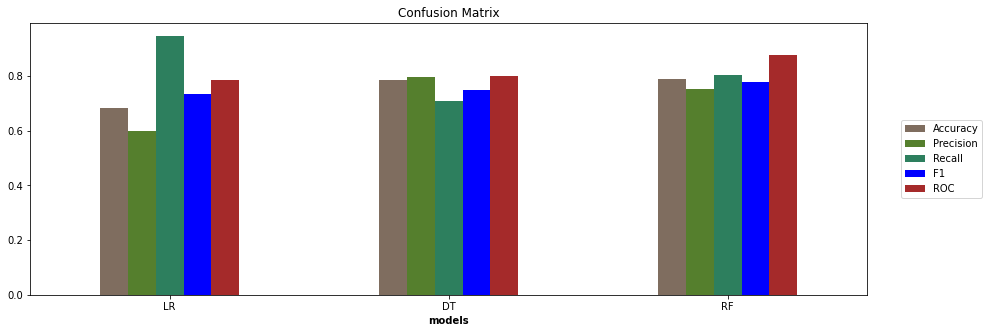

In [41]:
# confusion matrix for Pass 1
plot_cm_roc("Pass 1")

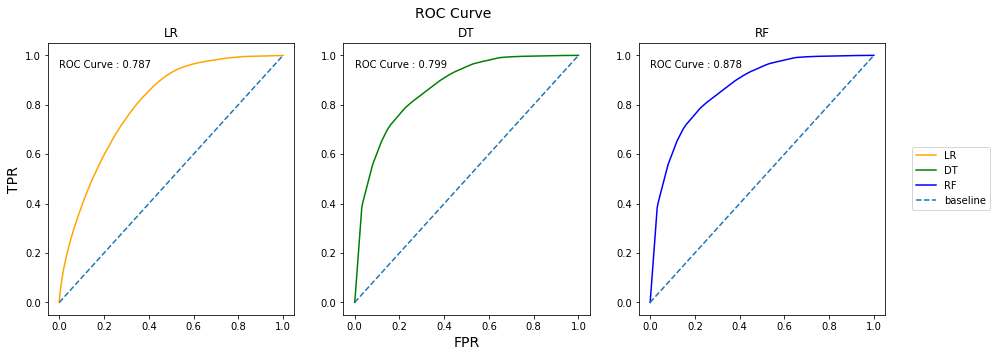

In [42]:
# Plot ROC Curve
plot_roc_curve(lrModel_p1, lrPredictions_p1, dtPredictions_p1, rfPredictions_p1, lr_roc, dt_roc, rf_roc)

**Based on summary of result for the final result of Pass 1**

Based on the [results](#pass1_result), Random Forest (RF) performs the better than Logistic Regression (LR) and Decision Tree (DT).  

For comparison purposes, we will continue run 3-Machine Learning algorithms for all passes, eventhough Random Forest theoretically is a better classifier.

In [43]:
# Feature Importance: Decision Tree
ExtractFeatureImp(dtModel_p1.stages[-1].bestModel.featureImportances, dtPredictions_p1, "features").head(20)

idx                                               name     score
449  448                     CAUGHT_FIRE_vec_Not Applicable  0.166513
445  444       LEVEL_OF_DAMAGE_vec_Extensive (unrepairable)  0.164124
443  442                          LEVEL_OF_DAMAGE_vec_Major  0.143592
307  306                VEHICLE_TYPE_vec_Motorcycle/Scooter  0.142539
442  441                       LEVEL_OF_DAMAGE_vec_Moderate  0.092716
250  249                                     SEX_vec_Female  0.055345
459  458                               NO_OCCUPANTS_vec_1-2  0.034232
394  393                          VEHICLE_DCA_vec_Vehicle 2  0.030543
11    10           ACCIDENT_TYPE_vec_Collision with vehicle  0.025770
427  426                         INITIAL_IMPACT_vec_Sidecar  0.021188
12    11    ACCIDENT_TYPE_vec_Collision with a fixed object  0.020449
395  394      VEHICLE_DCA_vec_Not involved in initial event  0.017789
113  112                              POLICE_ATTEND_vec_Yes  0.017656
402  401                VEHICLE_MOVEMENT_vec_Out of Control  0.010036
13    12                ACCIDENT_TYPE_vec_Struck Pedestrian  0.006596
34    33  DCA_vec_VEHICLE COLLIDES WITH VEHICLE PARKED O...  0.005176
51    50                       DCA_vec_FELL IN/FROM VEHICLE  0.004803
268  267               SEATING_POSITION_vec_Driver or rider  0.004433
361  360                VEHICLE_COLOUR_1_vec_Unknown or N/A  0.004395
14    13  ACCIDENT_TYPE_vec_Vehicle overturned (no colli...  0.003900

In [44]:
# Feature Importance: Random Forest
ExtractFeatureImp(rfModel_p1.stages[-1].bestModel.featureImportances, rfPredictions_p1, "features").head(20)

idx                                             name     score
264  263                 ROAD_USER_TYPE_vec_Motorcyclists  0.060515
307  306              VEHICLE_TYPE_vec_Motorcycle/Scooter  0.058018
445  444     LEVEL_OF_DAMAGE_vec_Extensive (unrepairable)  0.051459
395  394    VEHICLE_DCA_vec_Not involved in initial event  0.039309
443  442                        LEVEL_OF_DAMAGE_vec_Major  0.031699
266  265                    ROAD_USER_TYPE_vec_Bicyclists  0.031109
12    11  ACCIDENT_TYPE_vec_Collision with a fixed object  0.029346
402  401              VEHICLE_MOVEMENT_vec_Out of Control  0.028990
449  448                   CAUGHT_FIRE_vec_Not Applicable  0.028136
13    12              ACCIDENT_TYPE_vec_Struck Pedestrian  0.028022
250  249                                   SEX_vec_Female  0.027038
11    10         ACCIDENT_TYPE_vec_Collision with vehicle  0.026697
448  447                               CAUGHT_FIRE_vec_No  0.024892
444  443                        LEVEL_OF_DAMAGE_vec_Minor  0.024251
309  308                         VEHICLE_TYPE_vec_Bicycle  0.023375
447  446                   LEVEL_OF_DAMAGE_vec_Nil damage  0.020734
251  250                                SEX_vec_Not known  0.020434
242  241                DEG_URBAN_NAME_vec_RURAL_VICTORIA  0.018220
410  409                VEHICLE_CHANGED_DIRECTION_vec_N/A  0.017288
361  360              VEHICLE_COLOUR_1_vec_Unknown or N/A  0.015592

In data modelling, transformation, model selection & model assesment are interaction processes, the dataset will be further transformed in reducing the features values. This process involves making assumption with the best knowledge of the topic:  
- `AGE_GROUP`: group age into 25 to 64
- `NO_OF_OCCUPANTS`: group into range 1-2, 3-5, 6+
- `LIGHT_COND`: Dark or not Dark
- `DRIVER_INTENT`: group certain values into a sub-group
- `LEVEL_OF_DAMAGE`: group into Extensive, Major, Moderate, Minor, Nil, Unknown/Not Applicable
- `HELMET_BELT_WORN` turns into `SAFETY_WORN` (if child-seat, seat-belt or helmet are worn = Yes, otherwise No)
- `VEHICLE_TYPE_DESC`: grouping similar type of vehicle into a group and rename it to `VEHICLE_TYPE`
    etc..
    
After performing transformation on dataset, Pass 1 will be re-ran in order to obtained the latest infomation.   

*Please take note, in actual experiement, a few iteractive tests were done until reaching optimun's result of Pass 1. For assignment purposes, these iteractive steps are summaries into a single test - Pass 1.*  

[Back to Table of Contents](#toc) *Model Assessment: [Pass 1](#pass1), [Pass 3](#pass3), [Pass 4](#pass4), [Summary of all passes](#summary_pass)*
<a class="anchor" id="pass2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <h3> Pass 2 : Classifier with transformed and selected variables</h3>
    <p> <strong> Purpose </strong>: Removing variables that are impacting the classifier by removing variables that are mis-leading (i.e. impact model interpreatablity) and less influence in the classifier.</p>

</div>    

The most important activity, after first run (i.e. Pass 1), is to perform **feature selection**, in order to avoid overfitting the model and/or improve the interpreatability of the model.

After the first run (i.e. Pass 1), through feature importance of Decision Tree and Random Forest, there are few findings:  
* variables that are not meaningful but are part of Importance Features:
    - `CAUGHT_FIRE`: `CAUGHT_FIRE_vec_Not Applicable` (in Decision Tree) has the highest score (in Feature Importance), where it can be misleading for data modelling, especially for interpretability. Large amount of data provided as Not Applicable. This attribute is only provided about vehicle. Sometime the  road user type are pedestrian or bicyclist. Hence, including this variable in the classifier will be misleading.   
* variables have no influence in the classfier:
    - `SURFACE_MUDDY`, `SURFACE_SNOWY`, `SURFACE_ICY`: modelling will focus on whether surface is dry or not dry.   
    - `ATMOSPH_RAINING`, `ATMOSPH_SNOWING`, `ATMOSPH_FOG`, `ATMOSPH_SMOKE`, `ATMOSPH_DUST`, `ATMOSPH_STRONG_WINDS`: modelling will focus on whether the atmostpheric condition is clear or not clear.  
    - `LGA_NAME`, `REGION_NAME`
    - `FUEL_TYPE_DESC`,`TRAILER_TYPE`,`VEHICLE_DCA`
    
In Pass 2, we will removed the variables that are specified above.

*Please take note, in our actual experiment, a few iterative tests were done until reaching optimun's result of Pass 2. For assignment purposes, these iterative steps are summaries into a single test - Pass 2.*

In [45]:
## PERFORM FEATURE SELECTION

#Modify Features
#remove following columns before next pass
dellist = ["POLICE_ATTEND", 
           'SURFACE_MUDDY', 'SURFACE_SNOWY', 'SURFACE_ICY',
           'ATMOSPH_RAINING', 'ATMOSPH_SNOWING', 'ATMOSPH_FOG', 'ATMOSPH_SMOKE', 'ATMOSPH_DUST', 'ATMOSPH_STRONG_WINDS',
           'LGA_NAME', 'REGION_NAME',
           "FUEL_TYPE_DESC","TRAILER_TYPE","VEHICLE_DCA","CAUGHT_FIRE"]
categoryInputCols_p2 = [x for x in categoryInputCols_p1 if x not in dellist]

# define numberic columns
numericInputCols_p2 = ['ACCIDENT_MONTH']

# calculate total number of input variables
variables_p2 = len(categoryInputCols_p2) + len(numericInputCols_p2)

# Trim training/test dataset
train = train.select(*numericInputCols_p2, *categoryInputCols_p2,categoryOutputCol).cache()
test = test.select(*numericInputCols_p2, *categoryInputCols_p2,categoryOutputCol).cache()

# perform feature enginnering: StringIndexing, OHE and Vector Assembling
# Define Pipeline stages
stage_1,stage_2, stage_3 = feature_engineering(categoryInputCols_p2,categoryOutputCol,numericInputCols_p2)


In [46]:
# Perform Model Selection and Assessment: Logistic Regression
lrModel_p2,lrPredictions_p2,lr_acc,lr_pr,lr_rec,lr_f1 = lr_pipeline(stage_1, stage_2, stage_3,
                                                                    lrpg_params)


Elastic Net Parameter for the best model :  0.5

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|60948|
|  0.0|       1.0|18630|
|  1.0|       0.0|14907|
|  1.0|       1.0|52605|
+-----+----------+-----+


Confusion Matrix
Logistic regression| Accuracy: 0.772  Precision: 0.738  Recall: 0.779  F1: 0.758

Completed in : 0:01:12.350302



In [47]:
# Perform Model Selection and Assessment: Decision Tree
dtModel_p2,dtPredictions_p2, dt_acc, dt_pr, dt_rec, dt_f1= dt_pipeline(stage_1,stage_2,stage_3,
                                                                       dtpg_maxdepth)



Best Model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ba77dc61cf4e, depth=10, numNodes=805, numClasses=3, numFeatures=321

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|64238|
|  0.0|       1.0|15340|
|  1.0|       0.0|17953|
|  1.0|       1.0|49559|
+-----+----------+-----+


Confusion Matrix
Decision Trees| Accuracy: 0.774  Precision: 0.764  Recall: 0.734  F1: 0.749

Completed in : 0:02:47.118021



In [48]:
# Perform Model Selection and Assessment: Random Forest
rfModel_p2,rfPredictions_p2, rf_acc, rf_pr, rf_rec, rf_f1= rf_pipeline(stage_1,stage_2,stage_3,
                                                                       rfpg_maxdepth,rfpg_numtrees)


Best Model

RandomForestClassificationModel: uid=RandomForestClassifier_88faae63a616, numTrees=15, numClasses=3, numFeatures=321

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|60982|
|  0.0|       1.0|18596|
|  1.0|       0.0|14210|
|  1.0|       1.0|53302|
+-----+----------+-----+


Confusion Matrix
Random Forest| Accuracy: 0.777  Precision: 0.741  Recall: 0.79  F1: 0.765

Completed in : 0:05:52.946276



In [49]:
# Get summary of ROC for all ML
lr_roc, dt_roc, rf_roc = compute_roc(lrPredictions_p2,dtPredictions_p2,rfPredictions_p2)

Logistic Regression  |  areaUnderROC  :  0.82
Decision Trees       |  areaUnderROC  :  0.79
Random Forest        |  areaUnderROC  :  0.868


<a class="anchor" id="pass2_result"></a> **Summary of Confusion Matrix and ROC Curve**

In [50]:
# store Pass 2's results
p2_result = [("Pass 2", variables_p2, "LR", 
              "ElasticNet = "+str(lrModel_p2.stages[-1].bestModel.getElasticNetParam()),
              lr_acc, lr_pr, lr_rec, lr_f1, lr_roc),
             ("Pass 2", variables_p2, "DT", 
              "MaxDepth = "+ str(dtModel_p2.stages[-1].bestModel.getMaxDepth()),
              dt_acc, dt_pr, dt_rec, dt_f1, dt_roc),
             ("Pass 2", variables_p2, "RF", 
              "MaxDepth = "+ str(rfModel_p2.stages[-1].bestModel.getMaxDepth()) + ", NumTrees = "+ str(rfModel_p2.stages[-1].bestModel.getNumTrees),
              rf_acc, rf_pr, rf_rec, rf_f1, rf_roc)
            ]
df_p2 = pd.DataFrame(p2_result, columns= ["Pass","Variables","ML_Model","Best_Model_Param", "Accuracy","Precision","Recall","F1","ROC"])
df_results = df_results.append(df_p2, ignore_index=True )
df_results

Pass  Variables ML_Model              Best_Model_Param  Accuracy  \
0  Pass 1         51       LR              ElasticNet = 0.0     0.684   
1  Pass 1         51       DT                 MaxDepth = 10     0.784   
2  Pass 1         51       RF  MaxDepth = 15, NumTrees = 18     0.788   
3  Pass 2         35       LR              ElasticNet = 0.5     0.772   
4  Pass 2         35       DT                 MaxDepth = 10     0.774   
5  Pass 2         35       RF  MaxDepth = 15, NumTrees = 15     0.777   

   Precision  Recall     F1    ROC  
0      0.599   0.947  0.734  0.787  
1      0.797   0.708  0.750  0.799  
2      0.752   0.805  0.777  0.878  
3      0.738   0.779  0.758  0.820  
4      0.764   0.734  0.749  0.790  
5      0.741   0.790  0.765  0.868

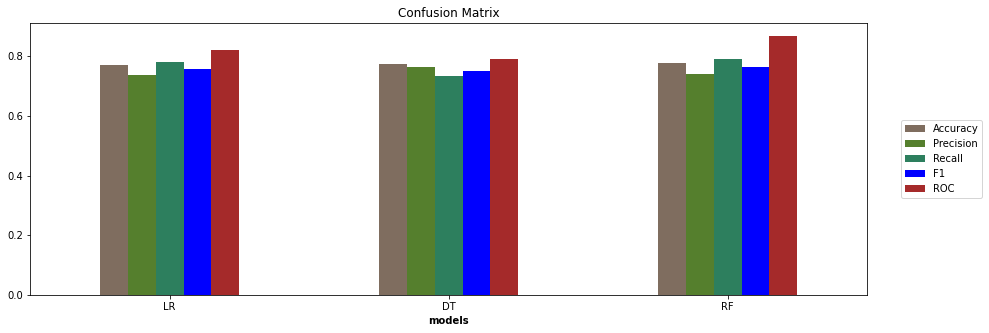

In [51]:
# confusion matrix for Pass 2
plot_cm_roc("Pass 2")

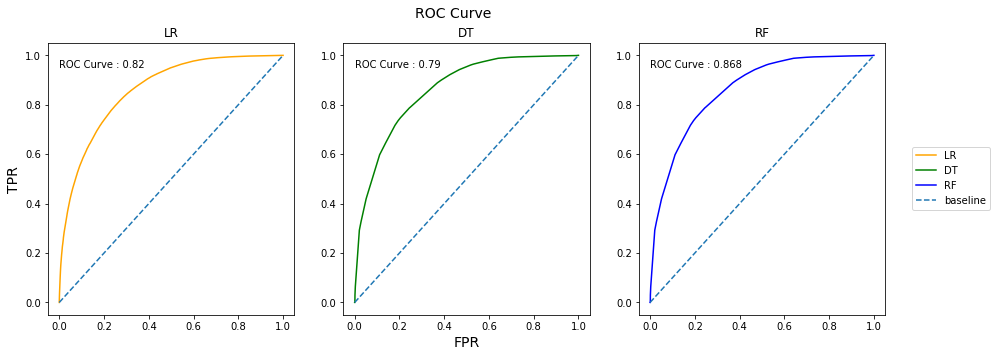

In [52]:
# plot roc curve
plot_roc_curve(lrModel_p2, lrPredictions_p2, dtPredictions_p2, rfPredictions_p2, lr_roc, dt_roc, rf_roc)

**Based on summary of result for the final result of Pass 2**

Based on the [results](#pass2_result), Random Forest (RF) continue performs the better than Logistic Regression (LR) and Decision Tree (DT) in term of ROC Curve. For Accuracy & Precision, LR has improved performance by having different ElasticNet parameter. 

Comparing Pass 2 and Pass 1 of Random Forest, the results (Confusion Matrix and ROC Curve) of Pass 2 are lower than Pass 1. This is expected as `CAUGHT_FIRE` is removed from classifier, where this variable's feature is part of the Top-20 Features Importance in both Decision Tree classifier and Random Forest classifier.

In [53]:
# Feature Importance: Decision Tree
ExtractFeatureImp(dtModel_p2.stages[-1].bestModel.featureImportances, dtPredictions_p2, "features").head(20)

idx                                               name     score
229  228                VEHICLE_COLOUR_1_vec_Unknown or N/A  0.144797
305  304                          LEVEL_OF_DAMAGE_vec_Major  0.142447
307  306       LEVEL_OF_DAMAGE_vec_Extensive (unrepairable)  0.136460
196  195                VEHICLE_TYPE_vec_Motorcycle/Scooter  0.123745
219  218                            VEHICLE_MAKE_vec_UNKN    0.108451
304  303                       LEVEL_OF_DAMAGE_vec_Moderate  0.089072
139  138                                     SEX_vec_Female  0.061014
317  316                               NO_OCCUPANTS_vec_1-2  0.033084
11    10           ACCIDENT_TYPE_vec_Collision with vehicle  0.026793
289  288                         INITIAL_IMPACT_vec_Sidecar  0.025696
12    11    ACCIDENT_TYPE_vec_Collision with a fixed object  0.025368
13    12                ACCIDENT_TYPE_vec_Struck Pedestrian  0.013911
264  263                VEHICLE_MOVEMENT_vec_Out of Control  0.009980
140  139                                  SEX_vec_Not known  0.006571
314  313                             TRAFFIC_CONTROL_vec_No  0.005873
34    33  DCA_vec_VEHICLE COLLIDES WITH VEHICLE PARKED O...  0.004931
14    13  ACCIDENT_TYPE_vec_Vehicle overturned (no colli...  0.003254
143  142                                  AGE_GROUP_vec_65+  0.003230
151  150                         ROAD_USER_TYPE_vec_Drivers  0.002864
145  144                                  AGE_GROUP_vec_0-4  0.002641

In [54]:
# Feature Importance: Random Forest
ExtractFeatureImp(rfModel_p2.stages[-1].bestModel.featureImportances, rfPredictions_p2, "features").head(20)

idx                                             name     score
196  195              VEHICLE_TYPE_vec_Motorcycle/Scooter  0.078267
307  306     LEVEL_OF_DAMAGE_vec_Extensive (unrepairable)  0.066528
12    11  ACCIDENT_TYPE_vec_Collision with a fixed object  0.045173
155  154                    ROAD_USER_TYPE_vec_Bicyclists  0.044638
306  305                        LEVEL_OF_DAMAGE_vec_Minor  0.041824
13    12              ACCIDENT_TYPE_vec_Struck Pedestrian  0.039191
309  308                   LEVEL_OF_DAMAGE_vec_Nil damage  0.031852
264  263              VEHICLE_MOVEMENT_vec_Out of Control  0.031795
305  304                        LEVEL_OF_DAMAGE_vec_Major  0.030702
139  138                                   SEX_vec_Female  0.029169
151  150                       ROAD_USER_TYPE_vec_Drivers  0.024195
293  292                           INITIAL_IMPACT_vec_N/A  0.023697
11    10         ACCIDENT_TYPE_vec_Collision with vehicle  0.019548
153  152                 ROAD_USER_TYPE_vec_Motorcyclists  0.017758
189  188                            REG_STATE_GRP_vec_N/A  0.014840
198  197                         VEHICLE_TYPE_vec_Bicycle  0.014620
138  137                                     SEX_vec_Male  0.014322
283  282                      ROAD_SURFACE_TYPE_vec_Paved  0.014318
217  216                             VEHICLE_MAKE_vec_N/A  0.013039
140  139                                SEX_vec_Not known  0.013014

[Back to Table of Contents](#toc)   *Model Assessment: [Pass 1](#pass1), [Pass 2](#pass2), [Pass 4](#pass4), [Summary of all passes](#summary_pass)*
<a class="anchor" id="pass3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <h3> Pass 3 : Classifier with Feature Importance </h3>
    <p> <strong> Purpose</strong>: machine learning modelling with Top-20 of feature importance of Decision Tree and Random Forest</p>

</div>    

Through feature importance of Decision Tree and Random Forest, there are few findings:
- features are similar in both Pass 1 and Pass 2.

In next pass will focus on the variables that are in the Top-20 of feature importance of Decision Tree and Random Forest. However, not all variables will be selected (e.g. `VEHICLE_COLOUR_1`) as the features is not meaningful (e.g. `VEHICLE_COLOUR_1`= "Unknown or N/A"). Through further exploration, these vehicle related attributes (e.g. `VEHICLE_MAKE`, `VEHICLE_AGE_GROUP`) with "N/A", "Not Applicable" or "Unknown" are records for pedestrian/bicyclist/motorcyclist.  


In [55]:
## PERFORM FEATURE SELECTION

# Define category variables
categoryInputCols_p3 = ['ACCIDENT_TYPE', 'SPEED_ZONE','DEG_URBAN_NAME',
                        'SEX', 'AGE_GROUP','ROAD_USER_TYPE', 
                        'VEHICLE_TYPE', 'VEHICLE_MOVEMENT', 'LEVEL_OF_DAMAGE']
#define numeric variables
numericInputCols_p3 = []

# calculate total number of input variables
variables_p3 = len(categoryInputCols_p3) + len(numericInputCols_p3)

# Trim training/test dataset
train = train.select(*numericInputCols_p3, *categoryInputCols_p3, categoryOutputCol).cache()
test = test.select(*numericInputCols_p3, *categoryInputCols_p3, categoryOutputCol).cache()


# perform feature enginnering: StringIndexing, OHE and Vector Assembling
# Define Pipeline stages
stage_1,stage_2, stage_3 = feature_engineering(categoryInputCols_p3, categoryOutputCol, numericInputCols_p3)


In [56]:
# Perform Model Selection and Assessment: Logistic Regression
lrModel_p3,lrPredictions_p3,lr_acc,lr_pr,lr_rec,lr_f1 = lr_pipeline(stage_1, stage_2, stage_3,
                                                                    lrpg_params)


Elastic Net Parameter for the best model :  0.0

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|62129|
|  0.0|       1.0|17449|
|  1.0|       0.0|16464|
|  1.0|       1.0|51048|
+-----+----------+-----+


Confusion Matrix
Logistic regression| Accuracy: 0.769  Precision: 0.745  Recall: 0.756  F1: 0.751

Completed in : 0:00:26.255452



In [57]:
# Perform Model Selection and Assessment: Decision Tree
dtModel_p3,dtPredictions_p3, dt_acc, dt_pr, dt_rec, dt_f1= dt_pipeline(stage_1,stage_2,stage_3,
                                                                       dtpg_maxdepth)


Best Model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_4cce5a28169f, depth=10, numNodes=615, numClasses=3, numFeatures=68

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|62887|
|  0.0|       1.0|16691|
|  1.0|       0.0|17963|
|  1.0|       1.0|49549|
+-----+----------+-----+


Confusion Matrix
Decision Trees| Accuracy: 0.764  Precision: 0.748  Recall: 0.734  F1: 0.741

Completed in : 0:00:39.875689



In [58]:
# Perform Model Selection and Assessment: Random Forest
rfModel_p3,rfPredictions_p3, rf_acc, rf_pr, rf_rec, rf_f1= rf_pipeline(stage_1,stage_2,stage_3, 
                                                                       rfpg_maxdepth,rfpg_numtrees)


Best Model

RandomForestClassificationModel: uid=RandomForestClassifier_ee2d39be027e, numTrees=18, numClasses=3, numFeatures=68

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|62321|
|  0.0|       1.0|17257|
|  1.0|       0.0|16146|
|  1.0|       1.0|51366|
+-----+----------+-----+


Confusion Matrix
Random Forest| Accuracy: 0.773  Precision: 0.749  Recall: 0.761  F1: 0.755

Completed in : 0:03:05.259823



In [59]:
# Get summary of ROC for all ML
lr_roc, dt_roc, rf_roc = compute_roc(lrPredictions_p3,dtPredictions_p3,rfPredictions_p3)

Logistic Regression  |  areaUnderROC  :  0.85
Decision Trees       |  areaUnderROC  :  0.812
Random Forest        |  areaUnderROC  :  0.863


<a class="anchor" id="pass3_result"></a> **Summary of Confusion Matrix and ROC Curve**

In [60]:
# store Pass 3's results
p3_result = [("Pass 3", variables_p3, "LR", 
              "ElasticNet = "+str(lrModel_p3.stages[-1].bestModel.getElasticNetParam()),
              lr_acc, lr_pr, lr_rec, lr_f1, lr_roc),
             ("Pass 3", variables_p3, "DT", 
              "MaxDepth = "+ str(dtModel_p3.stages[-1].bestModel.getMaxDepth()),
              dt_acc, dt_pr, dt_rec, dt_f1, dt_roc),
             ("Pass 3", variables_p3, "RF", 
              "MaxDepth = "+ str(rfModel_p3.stages[-1].bestModel.getMaxDepth()) + ", NumTrees = "+ str(rfModel_p3.stages[-1].bestModel.getNumTrees),
              rf_acc, rf_pr, rf_rec, rf_f1, rf_roc)
            ]
df_p3 = pd.DataFrame(p3_result, columns= ["Pass","Variables","ML_Model","Best_Model_Param", "Accuracy","Precision","Recall","F1","ROC"])
df_results = df_results.append(df_p3, ignore_index=True )

# display the modelling result
df_results

Pass  Variables ML_Model              Best_Model_Param  Accuracy  \
0  Pass 1         51       LR              ElasticNet = 0.0     0.684   
1  Pass 1         51       DT                 MaxDepth = 10     0.784   
2  Pass 1         51       RF  MaxDepth = 15, NumTrees = 18     0.788   
3  Pass 2         35       LR              ElasticNet = 0.5     0.772   
4  Pass 2         35       DT                 MaxDepth = 10     0.774   
5  Pass 2         35       RF  MaxDepth = 15, NumTrees = 15     0.777   
6  Pass 3          9       LR              ElasticNet = 0.0     0.769   
7  Pass 3          9       DT                 MaxDepth = 10     0.764   
8  Pass 3          9       RF  MaxDepth = 15, NumTrees = 18     0.773   

   Precision  Recall     F1    ROC  
0      0.599   0.947  0.734  0.787  
1      0.797   0.708  0.750  0.799  
2      0.752   0.805  0.777  0.878  
3      0.738   0.779  0.758  0.820  
4      0.764   0.734  0.749  0.790  
5      0.741   0.790  0.765  0.868  
6      0.745   0.756  0.751  0.850  
7      0.748   0.734  0.741  0.812  
8      0.749   0.761  0.755  0.863

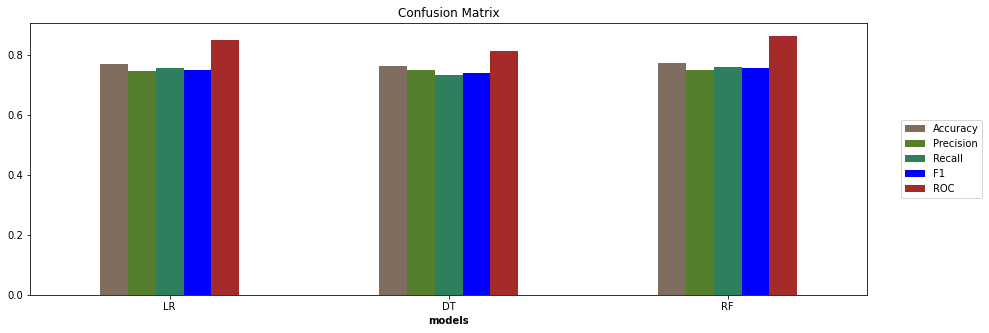

In [61]:
# display confusion matrix & roc for Pass 3
plot_cm_roc("Pass 3")

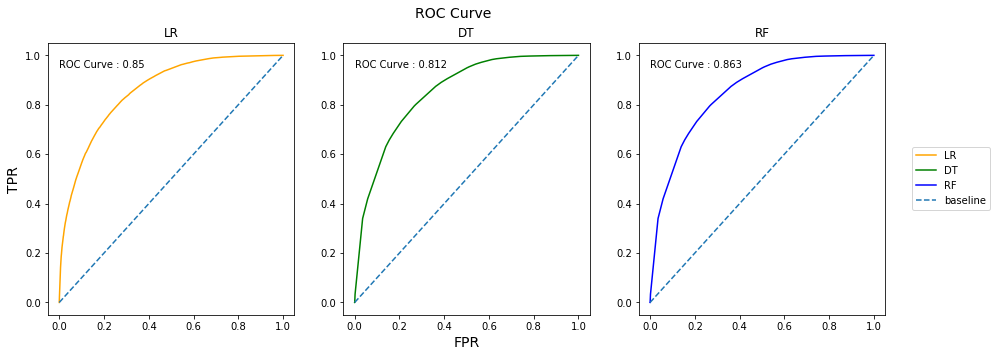

In [62]:
# plot ROC Curve
plot_roc_curve(lrModel_p3, lrPredictions_p3, dtPredictions_p3, rfPredictions_p3, lr_roc, dt_roc, rf_roc)

**Based on summary of result for the final result of Pass 3**

Based on the [results](#pass3_result), Random Forest (RF) continue performs the better than Logistic Regression (LR) and Decision Tree (DT) in term of ROC Curve. 

The overall result of the prediction model remains the approximately the same as in Pass 2, with a simpler classifier model (10-variables).

In [63]:
# Feature Importance: Decision Tree
ExtractFeatureImp(dtModel_p3.stages[-1].bestModel.featureImportances, dtPredictions_p3, "features").head(20)

idx                                               name     score
63   63                          LEVEL_OF_DAMAGE_vec_Major  0.160337
65   65       LEVEL_OF_DAMAGE_vec_Extensive (unrepairable)  0.145018
35   35                      ROAD_USER_TYPE_vec_Bicyclists  0.132534
40   40                VEHICLE_TYPE_vec_Motorcycle/Scooter  0.131498
34   34                     ROAD_USER_TYPE_vec_Pedestrians  0.126236
62   62                       LEVEL_OF_DAMAGE_vec_Moderate  0.103602
24   24                                     SEX_vec_Female  0.069723
0     0           ACCIDENT_TYPE_vec_Collision with vehicle  0.032302
1     1    ACCIDENT_TYPE_vec_Collision with a fixed object  0.026708
2     2                ACCIDENT_TYPE_vec_Struck Pedestrian  0.021986
31   31                         ROAD_USER_TYPE_vec_Drivers  0.014099
56   56                VEHICLE_MOVEMENT_vec_Out of Control  0.005907
28   28                                  AGE_GROUP_vec_65+  0.004318
54   54           VEHICLE_MOVEMENT_vec_Stationary/Stopping  0.004244
32   32                      ROAD_USER_TYPE_vec_Passengers  0.003958
3     3  ACCIDENT_TYPE_vec_Vehicle overturned (no colli...  0.003531
25   25                                  SEX_vec_Not known  0.002619
11   11                       SPEED_ZONE_vec_100-110 km/hr  0.001949
30   30                                  AGE_GROUP_vec_0-4  0.001412
13   13                     SPEED_ZONE_vec_Other/Not Known  0.001057

In [64]:
# Feature Importance: Random Forest
ExtractFeatureImp(rfModel_p3.stages[-1].bestModel.featureImportances, rfPredictions_p3, "features").head(20)

idx                                             name     score
65   65     LEVEL_OF_DAMAGE_vec_Extensive (unrepairable)  0.086773
33   33                 ROAD_USER_TYPE_vec_Motorcyclists  0.081094
42   42                         VEHICLE_TYPE_vec_Bicycle  0.069283
35   35                    ROAD_USER_TYPE_vec_Bicyclists  0.058864
63   63                        LEVEL_OF_DAMAGE_vec_Major  0.054464
67   67                   LEVEL_OF_DAMAGE_vec_Nil damage  0.050644
1     1  ACCIDENT_TYPE_vec_Collision with a fixed object  0.048425
64   64                        LEVEL_OF_DAMAGE_vec_Minor  0.048264
0     0         ACCIDENT_TYPE_vec_Collision with vehicle  0.047680
40   40              VEHICLE_TYPE_vec_Motorcycle/Scooter  0.047054
24   24                                   SEX_vec_Female  0.042397
41   41                  VEHICLE_TYPE_vec_Not Applicable  0.037087
56   56              VEHICLE_MOVEMENT_vec_Out of Control  0.034550
2     2              ACCIDENT_TYPE_vec_Struck Pedestrian  0.034547
34   34                   ROAD_USER_TYPE_vec_Pedestrians  0.034237
25   25                                SEX_vec_Not known  0.026344
31   31                       ROAD_USER_TYPE_vec_Drivers  0.022229
23   23                                     SEX_vec_Male  0.020549
62   62                     LEVEL_OF_DAMAGE_vec_Moderate  0.017462
32   32                    ROAD_USER_TYPE_vec_Passengers  0.014706

[Back to Table of Contents](#toc)   *Model Assessment: [Pass 1](#pass1), [Pass 2](#pass2), [Pass 3](#pass3), [Summary of all passes](#summary_pass)*
<a class="anchor" id="pass4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <h3> Pass 4 : Classifier with hyper-parameters tuning   </h3>
    <p> <strong> Purpose </strong>: machine learning modelling with different hyper-parameters  </p>
</div>    

After having a good and simpler data model, it is essential to further improve the models by perform hyper-parameter tuning. 

Next Pass, all models will use different parameters in the cross validation with the selected columns in Pass 4.

In [65]:
## PERFORM FEATURE SELECTION

# define category variables
categoryInputCols_p4 = categoryInputCols_p3

#define numeric variables
numericInputCols_p4 = numericInputCols_p3

# calculate total number of input variables
variables_p4 = len(categoryInputCols_p4) + len(numericInputCols_p4)

# Trim training/test dataset
train = train.select(*numericInputCols_p4, *categoryInputCols_p4, categoryOutputCol).cache()
test = test.select(*numericInputCols_p4, *categoryInputCols_p4, categoryOutputCol).cache()

# perform feature enginnering: StringIndexing, OHE and Vector Assembling
# Define Pipeline stages
stage_1,stage_2, stage_3 = feature_engineering(categoryInputCols_p4, categoryOutputCol, numericInputCols_p4)

In [66]:
# Perform further hyper-parameters tuning
#Logistic Regress Cross Validation parameters
lrpg_params_p4 = [0.2, 0.4, 0.8]

#Decision Tree Cross Validation ParamGrid parameters
dtpg_maxdepth_p4 = [11,15,18]   

#Random Forest CrossValidation parameters
rfpg_maxdepth_p4 = [17]   
rfpg_numtrees_p4 = [16,18,20]  

In [67]:
# Perform Model Selection and Assessment: Logistic Regression
lrModel_p4,lrPredictions_p4,lr_acc,lr_pr,lr_rec,lr_f1 = lr_pipeline(stage_1, stage_2, stage_3,
                                                                    lrpg_params_p4)


Elastic Net Parameter for the best model :  0.8

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|62129|
|  0.0|       1.0|17449|
|  1.0|       0.0|16464|
|  1.0|       1.0|51048|
+-----+----------+-----+


Confusion Matrix
Logistic regression| Accuracy: 0.769  Precision: 0.745  Recall: 0.756  F1: 0.751

Completed in : 0:00:17.402841



In [68]:
# Perform Model Selection and Assessment: Decision Tree
dtModel_p4,dtPredictions_p4, dt_acc, dt_pr, dt_rec, dt_f1= dt_pipeline(stage_1,stage_2,stage_3,
                                                                       dtpg_maxdepth_p4)


Best Model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_570aaa8ef97d, depth=11, numNodes=903, numClasses=3, numFeatures=68

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|61862|
|  0.0|       1.0|17716|
|  1.0|       0.0|16553|
|  1.0|       1.0|50959|
+-----+----------+-----+


Confusion Matrix
Decision Trees| Accuracy: 0.767  Precision: 0.742  Recall: 0.755  F1: 0.748

Completed in : 0:00:48.509340



In [69]:
# Perform Model Selection and Assessment: Random Forest
rfModel_p4,rfPredictions_p4, rf_acc, rf_pr, rf_rec, rf_f1= rf_pipeline(stage_1,stage_2,stage_3,
                                                                       rfpg_maxdepth_p4, rfpg_numtrees_p4)


Best Model

RandomForestClassificationModel: uid=RandomForestClassifier_338e7a038e8f, numTrees=20, numClasses=3, numFeatures=68

Summary
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|62040|
|  0.0|       1.0|17538|
|  1.0|       0.0|15754|
|  1.0|       1.0|51758|
+-----+----------+-----+


Confusion Matrix
Random Forest| Accuracy: 0.774  Precision: 0.747  Recall: 0.767  F1: 0.757

Completed in : 0:04:23.182831



In [70]:
# Get summary of ROC for all ML
lr_roc, dt_roc, rf_roc = compute_roc(lrPredictions_p4, dtPredictions_p4, rfPredictions_p4)

Logistic Regression  |  areaUnderROC  :  0.85
Decision Trees       |  areaUnderROC  :  0.817
Random Forest        |  areaUnderROC  :  0.864


<a class="anchor" id="pass4_result"></a> **Summary of Confusion Matrix and ROC Curve**

In [71]:
# store Pass 4's results
p4_result = [("Pass 4", variables_p4, "LR", 
              "ElasticNet = "+str(lrModel_p4.stages[-1].bestModel.getElasticNetParam()),
              lr_acc, lr_pr, lr_rec, lr_f1, lr_roc),
             ("Pass 4", variables_p4, "DT", 
              "MaxDepth = "+ str(dtModel_p4.stages[-1].bestModel.getMaxDepth()),
              dt_acc, dt_pr, dt_rec, dt_f1, dt_roc),
             ("Pass 4", variables_p4, "RF", 
              "MaxDepth = "+ str(rfModel_p4.stages[-1].bestModel.getMaxDepth()) + ", NumTrees = "+ str(rfModel_p4.stages[-1].bestModel.getNumTrees),
              rf_acc, rf_pr, rf_rec, rf_f1, rf_roc)
            ]
df_p4 = pd.DataFrame(p4_result, columns= ["Pass","Variables","ML_Model","Best_Model_Param", "Accuracy","Precision","Recall","F1","ROC"])
df_results = df_results.append(df_p4, ignore_index=True )
df_results

Pass  Variables ML_Model              Best_Model_Param  Accuracy  \
0   Pass 1         51       LR              ElasticNet = 0.0     0.684   
1   Pass 1         51       DT                 MaxDepth = 10     0.784   
2   Pass 1         51       RF  MaxDepth = 15, NumTrees = 18     0.788   
3   Pass 2         35       LR              ElasticNet = 0.5     0.772   
4   Pass 2         35       DT                 MaxDepth = 10     0.774   
5   Pass 2         35       RF  MaxDepth = 15, NumTrees = 15     0.777   
6   Pass 3          9       LR              ElasticNet = 0.0     0.769   
7   Pass 3          9       DT                 MaxDepth = 10     0.764   
8   Pass 3          9       RF  MaxDepth = 15, NumTrees = 18     0.773   
9   Pass 4          9       LR              ElasticNet = 0.8     0.769   
10  Pass 4          9       DT                 MaxDepth = 11     0.767   
11  Pass 4          9       RF  MaxDepth = 17, NumTrees = 20     0.774   

    Precision  Recall     F1    ROC  
0       0.599   0.947  0.734  0.787  
1       0.797   0.708  0.750  0.799  
2       0.752   0.805  0.777  0.878  
3       0.738   0.779  0.758  0.820  
4       0.764   0.734  0.749  0.790  
5       0.741   0.790  0.765  0.868  
6       0.745   0.756  0.751  0.850  
7       0.748   0.734  0.741  0.812  
8       0.749   0.761  0.755  0.863  
9       0.745   0.756  0.751  0.850  
10      0.742   0.755  0.748  0.817  
11      0.747   0.767  0.757  0.864

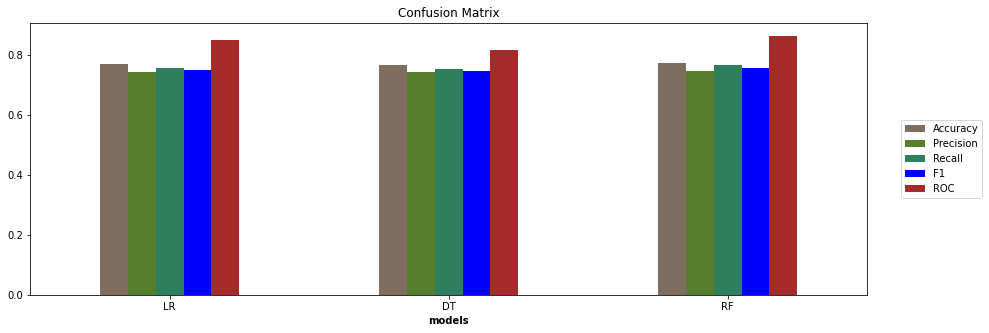

In [72]:
# confusion matrix for Pass 4
plot_cm_roc("Pass 4")

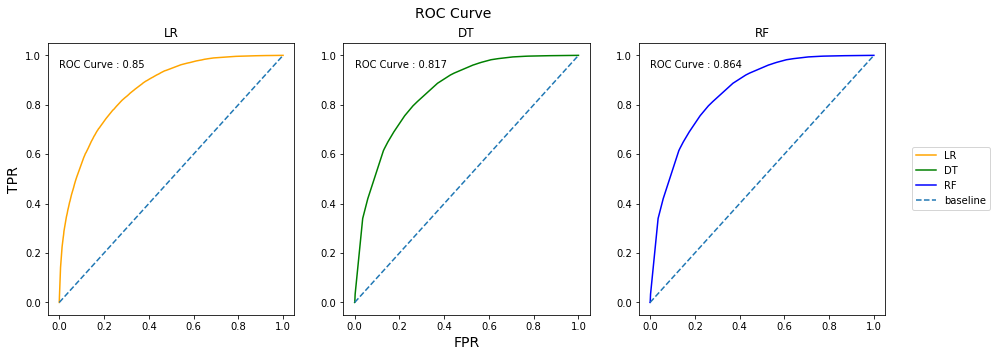

In [73]:
# Plot ROC Curve
plot_roc_curve(lrModel_p4, lrPredictions_p4,dtPredictions_p4,rfPredictions_p4, lr_roc, dt_roc, rf_roc)

**Based on summary of result for the final result of Pass 4**

Based on the [results](#pass4_result), Random Forest (RF) continue performs the better than Logistic Regression (LR) and Decision Tree (DT) in term of ROC Curve. 

In [74]:
# Feature Importance: Decision Tree
ExtractFeatureImp(dtModel_p4.stages[-1].bestModel.featureImportances, dtPredictions_p4, "features").head(20)

idx                                               name     score
63   63                          LEVEL_OF_DAMAGE_vec_Major  0.157642
65   65       LEVEL_OF_DAMAGE_vec_Extensive (unrepairable)  0.142581
35   35                      ROAD_USER_TYPE_vec_Bicyclists  0.130307
40   40                VEHICLE_TYPE_vec_Motorcycle/Scooter  0.129288
34   34                     ROAD_USER_TYPE_vec_Pedestrians  0.124114
62   62                       LEVEL_OF_DAMAGE_vec_Moderate  0.101886
24   24                                     SEX_vec_Female  0.068551
0     0           ACCIDENT_TYPE_vec_Collision with vehicle  0.031840
1     1    ACCIDENT_TYPE_vec_Collision with a fixed object  0.026367
2     2                ACCIDENT_TYPE_vec_Struck Pedestrian  0.021617
31   31                         ROAD_USER_TYPE_vec_Drivers  0.017044
28   28                                  AGE_GROUP_vec_65+  0.008563
56   56                VEHICLE_MOVEMENT_vec_Out of Control  0.007096
54   54           VEHICLE_MOVEMENT_vec_Stationary/Stopping  0.004444
32   32                      ROAD_USER_TYPE_vec_Passengers  0.003953
3     3  ACCIDENT_TYPE_vec_Vehicle overturned (no colli...  0.003534
67   67                     LEVEL_OF_DAMAGE_vec_Nil damage  0.002856
25   25                                  SEX_vec_Not known  0.002575
30   30                                  AGE_GROUP_vec_0-4  0.002220
26   26                                AGE_GROUP_vec_25-64  0.002192

In [75]:
# Feature Importance: Random Forest
ExtractFeatureImp(rfModel_p4.stages[-1].bestModel.featureImportances, rfPredictions_p4, "features").head(20)

idx                                             name     score
65   65     LEVEL_OF_DAMAGE_vec_Extensive (unrepairable)  0.089228
40   40              VEHICLE_TYPE_vec_Motorcycle/Scooter  0.073496
42   42                         VEHICLE_TYPE_vec_Bicycle  0.073223
1     1  ACCIDENT_TYPE_vec_Collision with a fixed object  0.070340
33   33                 ROAD_USER_TYPE_vec_Motorcyclists  0.053752
41   41                  VEHICLE_TYPE_vec_Not Applicable  0.050729
64   64                        LEVEL_OF_DAMAGE_vec_Minor  0.047542
67   67                   LEVEL_OF_DAMAGE_vec_Nil damage  0.040320
63   63                        LEVEL_OF_DAMAGE_vec_Major  0.039054
24   24                                   SEX_vec_Female  0.038286
35   35                    ROAD_USER_TYPE_vec_Bicyclists  0.037900
34   34                   ROAD_USER_TYPE_vec_Pedestrians  0.037087
2     2              ACCIDENT_TYPE_vec_Struck Pedestrian  0.036798
56   56              VEHICLE_MOVEMENT_vec_Out of Control  0.034175
0     0         ACCIDENT_TYPE_vec_Collision with vehicle  0.032563
31   31                       ROAD_USER_TYPE_vec_Drivers  0.031010
25   25                                SEX_vec_Not known  0.027145
23   23                                     SEX_vec_Male  0.022118
62   62                     LEVEL_OF_DAMAGE_vec_Moderate  0.017338
37   37                             VEHICLE_TYPE_vec_Car  0.012210

[Back to Table of Contents](#toc)   *Model Assessment: [Pass 1](#pass1), [Pass 2](#pass2), [Pass 3](#pass3), [Pass 4](#pass4)*
<a class="anchor" id="summary_pass"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <h4> Summary & Selecting the best model  </h4></div>  

In [76]:
# Rank the Pass based on ROC
df_results['rank_acc/pass'] = df_results.groupby('Pass')['Accuracy'].rank(method='dense', ascending=False).astype(int)
df_results['rank_f1/pass'] = df_results.groupby('Pass')['F1'].rank(method='dense', ascending=False).astype(int)
df_results['rank_roc/pass'] = df_results.groupby('Pass')['ROC'].rank(method='dense', ascending=False).astype(int)
df_results['rank_acc'] = df_results['Accuracy'].rank(method='dense', ascending=False).astype(int)
df_results['rank_f1'] = df_results['F1'].rank(method='dense', ascending=False).astype(int)
df_results['rank_roc'] = df_results['ROC'].rank(method='dense', ascending=False).astype(int)


In [77]:
# set dataframe formatting
pd.set_option('display.precision',3)

#Highlight Best Model
color = ((df_results.ML_Model == 'RF') & (df_results.Pass == 'Pass 4')).map({True: 'background-color: yellow', False: ''})
df_results.style.apply(lambda s: color)

In general, Random Forest (RF) produces a better accuracy and F1 model in all passes.  

Pass 1 has higher ROC and Accuracy due to features `CAUGHT_FIRE = Not known`, where is carried less meaning in the model. 
Pass 2 contains 35-variables where considers a complex modelling method. Therefore, Pass 1 and Pass 2 will be excluded from selecting as the best model. 

Between Pass 3 and Pass 4, Random Forest of Pass 4 produces the best model because it has the highest Accuracy, F1 and ROC. This model can predict accurately on the person suffer injury from the road accidents. 

In [78]:
# select best model
best_model = rfModel_p4
best_categoryInputCols = categoryInputCols_p4
best_numericInputCols = numericInputCols_p4

bestPredictions = rfPredictions_p4 # for tree visualisation

In [79]:
# Saves the model to the filesystem
best_model.write().overwrite().save('road_accident_prediction_model2')

In [80]:
# view the variables
print(best_numericInputCols + best_categoryInputCols)

['ACCIDENT_TYPE', 'SPEED_ZONE', 'DEG_URBAN_NAME', 'SEX', 'AGE_GROUP', 'ROAD_USER_TYPE', 'VEHICLE_TYPE', 'VEHICLE_MOVEMENT', 'LEVEL_OF_DAMAGE']




**Datasets for road_accident_prediction_model:**  
(in order)
- **Details of the accidents:**: `ACCIDENT_MONTH`,  `ACCIDENT_TYPE`, `SPEED_ZONE`
- **Details of the accident's location:** `DEG_URBAN_NAME` 
- **Details of person involved in the accident:** `SEX`, `AGE_GROUP`, `ROAD_USER_TYPE`
- **Details of vehicle involed in the accident:**  `VEHICLE_TYPE`,  `VEHICLE_MOVEMENT`, `LEVEL_OF_DAMAGE`


In [81]:
# display the unique values for each variables
[df.select(c).distinct().sort(c).show(truncate=False) for c in best_categoryInputCols]

+---------------------------------+
|ACCIDENT_TYPE                    |
+---------------------------------+
|Collision with a fixed object    |
|Collision with vehicle           |
|Fall from or in moving vehicle   |
|No collision and no object struck|
|Other accident                   |
|Struck Pedestrian                |
|Struck animal                    |
|Vehicle overturned (no collision)|
|collision with some other object |
+---------------------------------+

+---------------+
|SPEED_ZONE     |
+---------------+
|100-110 km/hr  |
|30-40 km/hr    |
|50-60 km/hr    |
|70-75 km/hr    |
|80-90 km/hr    |
|Other/Not Known|
+---------------+

+-----------------------+
|DEG_URBAN_NAME         |
+-----------------------+
|LARGE_PROVINCIAL_CITIES|
|MELBOURNE_CBD          |
|MELB_URBAN             |
|None                   |
|RURAL_VICTORIA         |
|SMALL_CITIES           |
|SMALL_TOWNS            |
|TOWNS                  |
+-----------------------+

+---------+
|SEX      |
+---------+
|

[None, None, None, None, None, None, None, None, None]

[Back to Table of Contents](#toc)
<a class="anchor" id="visualisation"></a>
<div style="background:rgba(0,80,80,0.2);padding:10px;border-radius:4px"><h2>Tree Visualisation</h2>
<hr/>
</div>

In [82]:
# display the best model tree
display_clean_tree(best_model, bestPredictions, 'PERSON_INJURED')

RandomForestClassificationModel: uid=RandomForestClassifier_338e7a038e8f, numTrees=20, numClasses=3, numFeatures=68
  Tree 0 (weight 1.0):
    If (VEHICLE_TYPE is Bicycle)
     If (VEHICLE_TYPE is Motorcycle/Scooter)
      If (ROAD_USER_TYPE is Pedestrians)
       If (SPEED_ZONE is 100-110 km/hr)
        If (LEVEL_OF_DAMAGE is Minor)
         If (LEVEL_OF_DAMAGE is Extensive (unrepairable))
          If (VEHICLE_TYPE is Car)
           If (ROAD_USER_TYPE is Unknown)
            If (ACCIDENT_TYPE is Collision with a fixed object)
             If (SEX is Female)
              If (VEHICLE_MOVEMENT is Other)
               If (LEVEL_OF_DAMAGE is Nil damage)
                If (ACCIDENT_TYPE is Struck animal)
                 If (VEHICLE_MOVEMENT is Out of Control)
                  If (LEVEL_OF_DAMAGE is Major)
                   	===> PERSON_INJURED = FALSE
                  Else (LEVEL_OF_DAMAGE is not Major)
                   If (ROAD_USER_TYPE is Passengers)
                    If (AC

In [83]:
# keeping track on processing time
nbend = time.time()
print(nbend - nbstart)

2106.6319184303284


In [84]:
print("\nCompleted in : "+ str(datetime.timedelta(seconds=nbend-nbstart)) + "\n")


Completed in : 0:35:06.631918



In [85]:
# stop spark session
#spark.stop()

In [86]:
# store prediction results
export_csv = bestPredictions.select('ACCIDENT_TYPE', 'ACCIDENT_TYPE_index',
                                     'SPEED_ZONE','SPEED_ZONE_index',
                                     'DEG_URBAN_NAME','DEG_URBAN_NAME_index',
                                     'SEX', 'SEX_index',
                                     'AGE_GROUP', 'AGE_GROUP_index',
                                     'ROAD_USER_TYPE', 'ROAD_USER_TYPE_index',
                                     'VEHICLE_TYPE', 'VEHICLE_TYPE_index', 
                                     'VEHICLE_MOVEMENT', 'VEHICLE_MOVEMENT_index',
                                     'LEVEL_OF_DAMAGE','LEVEL_OF_DAMAGE_index',
                                     'PERSON_INJURED','label','prediction')
#csv
export_csv.write.mode("overwrite").csv("bestPredictions/test100.csv", header=True)

# Parquet 
bestPredictions.write.mode("overwrite").parquet("bestPredictions/test100.parquet")